In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import scanpy as sc
import session_info
import matplotlib.pyplot as plt
import seaborn as sns


import os

In [2]:
session_info.show()

In [3]:
sc.settings.set_figure_params(dpi=120)

# Read in ID metadata

In [4]:
multiplexed_samples = pd.read_csv('/nfs/team205/heart/mapped/cellranger-arc200/csv/multiome-foetal_20221221.csv')
multiplexed_samples

# read in metadata
meta = pd.read_csv('/nfs/team205/heart/anndata_objects/Foetal/metadata/HeartTeamSamples_Mappeddata_20221223.csv', sep = ',', index_col = None)
meta = meta[meta['Publication']=='Foetal']
meta = meta[['sangerID', 'combinedID',
       'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender',
       'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed',
       'status']]

# select samples
meta = meta[meta['combinedID'].isin(multiplexed_samples['combinedID'])]

# select Multiome-ATAC
meta = meta[meta['modality']=='Multiome-ATAC']

# reindex
meta.index = range(len(meta))

pd.set_option('max_colwidth', None)
meta[['combinedID',
       'donor', 'region', 'age', 'gender']]

combinedID                donor  \
0  7089STDY13216920_BHF_F_Hea13242527         Hst39, Hst40   
1  7089STDY13216921_BHF_F_Hea13242528         Hst39, Hst40   
2  7089STDY13216922_BHF_F_Hea13242529  Hst36, Hst39, Hst40   
3  7089STDY13216923_BHF_F_Hea13242530  Hst36, Hst39, Hst40   
4  7089STDY13216924_BHF_F_Hea13242531                Hst39   
5  7089STDY13216925_BHF_F_Hea13242532                Hst40   
6  7089STDY13216926_BHF_F_Hea13242533                Hst39   
7  7089STDY13216927_BHF_F_Hea13242534                Hst36   

                                                          region          age  \
0                                   Aorta (Hst39), Nodes (Hst40)  multiplexed   
1                                   Aorta (Hst39), Nodes (Hst40)  multiplexed   
2  Heart (Hst36), Heart-wo-nodes (Hst39), Heart-wo-nodes (Hst40)  multiplexed   
3  Heart (Hst36), Heart-wo-nodes (Hst39), Heart-wo-nodes (Hst40)  multiplexed   
4                                                          Nodes      PCW-15w   
5                                                 Heart-wo-nodes      PCW-14w   
6                                                 Heart-wo-nodes      PCW-15w   
7                                                          Heart      PCW-12w   

        gender  
0  multiplexed  
1  multiplexed  
2  multiplexed  
3  multiplexed  
4       Female  
5         Male  
6       Female  
7       Female

In [5]:
multiplexed_samples = ['7089STDY13216920_BHF_F_Hea13242527','7089STDY13216921_BHF_F_Hea13242528',
                       '7089STDY13216922_BHF_F_Hea13242529','7089STDY13216923_BHF_F_Hea13242530']

# Read in Multiome data

In [6]:
# post-cellbender
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/QC/multiome_RNA_foetal_prefilter.h5ad')

# only multiplexed data (plus relevant single genotype samples)
adata = adata[adata.obs['combinedID'].isin(list(meta['combinedID']))]

adata

View of AnnData object with n_obs × n_vars = 194705 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval'
    var: 'gene_name', 'feature_type', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-10', 'ambient_expression-11', 'ambient_expression-12', 'ambient_expression-13', 'ambient_expression-14', 'ambient_expression-15', 'ambient_expression-16', 'ambient_expression-17', 'ambient_expression-18', 'ambient_expression-19', 'ambient_expression-2', 'ambient_expression-20', 'ambient_expression-21', 'ambient_expression-22', 'ambient_expression-23', 'ambient_expression-24', 'ambient_expression-25', 'ambient_expression-26', 'ambient_expression-27', 'ambient_expression-28', 'ambient_expression-29', 

In [7]:
adata.obs['combinedID'].value_counts()

7089STDY13216924_BHF_F_Hea13242531    40000
7089STDY13216925_BHF_F_Hea13242532    30453
7089STDY13216920_BHF_F_Hea13242527    27498
7089STDY13216927_BHF_F_Hea13242534    24666
7089STDY13216926_BHF_F_Hea13242533    24602
7089STDY13216921_BHF_F_Hea13242528    24211
7089STDY13216922_BHF_F_Hea13242529    21402
7089STDY13216923_BHF_F_Hea13242530     1873
Name: combinedID, dtype: int64

In [8]:
adata.obs[adata.obs['combinedID'].isin(multiplexed_samples)]['combinedID'].value_counts()

7089STDY13216920_BHF_F_Hea13242527    27498
7089STDY13216921_BHF_F_Hea13242528    24211
7089STDY13216922_BHF_F_Hea13242529    21402
7089STDY13216923_BHF_F_Hea13242530     1873
7089STDY13216924_BHF_F_Hea13242531        0
7089STDY13216925_BHF_F_Hea13242532        0
7089STDY13216926_BHF_F_Hea13242533        0
7089STDY13216927_BHF_F_Hea13242534        0
Name: combinedID, dtype: int64

# Add SOC result

In [9]:
# read in
soc = pd.read_csv('/nfs/team205/heart/mapped/cellranger-arc200/SOC_out/SOC-clusters_multiome-foetal_20221221.csv',
                 index_col=0)
print(soc.shape)
soc.head()

(74984, 10)


sample  \
obsnames                                                                                    
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  7089STDY13216920_BHF_F_Hea13242527   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  7089STDY13216920_BHF_F_Hea13242527   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  7089STDY13216920_BHF_F_Hea13242527   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  7089STDY13216920_BHF_F_Hea13242527   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  7089STDY13216920_BHF_F_Hea13242527   

                                                                  barcode  \
obsnames                                                                    
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  GCCCTCATCCTAGTAA-1   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  ACTCGCTTCCTAGTAA-1   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  TGGTCCTTCCGTGACA-1   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  TTCAGTTTCCGCTAGA-1   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  GTCAATATCATCCACC-1   

                                                        status assignment  \
obsnames                                                                    
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  singlet          1   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  singlet          0   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  singlet          0   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  singlet          1   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  singlet          0   

                                                       log_prob_singleton  \
obsnames                                                                    
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1        -1804.326000   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1        -2300.029401   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1        -7138.100603   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1       -16501.683493   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1       -15506.974212   

                                                       log_prob_doublet  \
obsnames                                                                  
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1      -2214.313429   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1      -2917.765214   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1      -8752.227197   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1     -20232.559001   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1     -16020.863109   

                                                           cluster0  \
obsnames                                                              
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  -3702.970109   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  -2300.029401   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  -7138.100603   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1 -36208.064251   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1 -15506.974212   

                                                           cluster1  cluster2  \
obsnames                                                                        
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  -1804.326000       NaN   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  -4878.822776       NaN   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1 -15143.684314       NaN   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1 -16501.683493       NaN   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1 -25471.286877       NaN   

                                                      donor_assignment  
obsnames                                                                
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1            Hst40  


In [10]:
# add
col_to_add = ['status', 'assignment', 'log_prob_singleton',
               'log_prob_doublet', 'cluster0', 'cluster1', 'cluster2',
               'donor_assignment']
adata.obs[[f'SOC | {x}' for x in col_to_add]] = soc[col_to_add].reindex(adata.obs_names)
adata.obs.head()

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  """


latent_RT_efficiency  \
barcode                                                                       
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1              7.888165   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1              7.925703   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1              6.652470   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1              6.054835   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1              5.798558   

                                                       latent_cell_probability  \
barcode                                                                          
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1                 0.999996   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1                 0.999979   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1                 0.999995   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1                 0.999993   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1                 0.999992   

                                                       latent_scale  \
barcode                                                               
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  19645.132812   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  20618.298828   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  17098.843750   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  15610.971680   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  16973.482422   

                                                               sangerID  \
barcode                                                                   
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  7089STDY13216920   

                                                                               combinedID  \
barcode                                                                                     
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  7089STDY13216920_BHF_F_Hea13242527   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  7089STDY13216920_BHF_F_Hea13242527   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  7089STDY13216920_BHF_F_Hea13242527   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  7089STDY13216920_BHF_F_Hea13242527   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  7089STDY13216920_BHF_F_Hea13242527   

                                                              donor  \
barcode                                                               
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  Hst39, Hst40   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  Hst39, Hst40   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  Hst39, Hst40   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  Hst39, Hst40   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  Hst39, Hst40   

                                                      donor_type  \
barcode                                                            
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1         na   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1         na   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1         na   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1         na   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1         na   

                                                                             region  \
barcode                                                                               
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  Aorta (Hst39), Nodes (Hst40)   
7089STDY132169

In [11]:
adata.obs['SOC | donor_assignment'].value_counts()

Hst39               36323
Hst40               20246
donor_unassigned    13322
Hst36                5093
Name: SOC | donor_assignment, dtype: int64

In [12]:
adata.obs[adata.obs['SOC | donor_assignment']!='donor_unassigned']['SOC | donor_assignment'].value_counts()

Hst39    36323
Hst40    20246
Hst36     5093
Name: SOC | donor_assignment, dtype: int64

In [13]:
adata.obs['SOC | status'].value_counts()

singlet       63170
doublet        8383
unassigned     3431
Name: SOC | status, dtype: int64

# Add CMO result

In [14]:
# read in
cmo = pd.read_csv('/nfs/team205/heart/mapped/CMO/result_summary/CMO-result_multiome-foetal_20230207.csv',
                 index_col=0)
print(cmo.shape)
cmo.head()

(74984, 8)


combinedID  \
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  7089STDY13216920_BHF_F_Hea13242527   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  7089STDY13216920_BHF_F_Hea13242527   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  7089STDY13216920_BHF_F_Hea13242527   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  7089STDY13216920_BHF_F_Hea13242527   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  7089STDY13216920_BHF_F_Hea13242527   

                                                          ratio  top_count  \
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  3.461564   125274.0   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  3.092936    88226.0   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  2.425848    64382.0   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  3.163533   115915.0   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  1.360772    51478.0   

                                                      donor_assignment  \
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1            Hst40   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1            Hst39   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1            Hst39   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1            Hst40   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1            Hst40   

                                                       n_donor_assigned  \
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1                 1   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1                 1   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1                 1   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1                 1   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1                 1   

                                                          Hst40    Hst39  \
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  125274.0  36190.0   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1   28525.0  88226.0   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1   26540.0  64382.0   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  115915.0  36641.0   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1   51478.0  37830.0   

                                                       Hst36  
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1    NaN  
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1    NaN  
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1    NaN  
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1    NaN  
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1    NaN

In [15]:
# add
col_to_add = ['ratio','top_count', 'donor_assignment', 'n_donor_assigned','Hst40', 'Hst39', 'Hst36']
adata.obs[[f'CMO | {x}' for x in col_to_add]] = cmo[col_to_add].reindex(adata.obs_names)
adata.obs.head()

latent_RT_efficiency  \
barcode                                                                       
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1              7.888165   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1              7.925703   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1              6.652470   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1              6.054835   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1              5.798558   

                                                       latent_cell_probability  \
barcode                                                                          
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1                 0.999996   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1                 0.999979   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1                 0.999995   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1                 0.999993   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1                 0.999992   

                                                       latent_scale  \
barcode                                                               
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  19645.132812   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  20618.298828   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  17098.843750   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  15610.971680   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  16973.482422   

                                                               sangerID  \
barcode                                                                   
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  7089STDY13216920   

                                                                               combinedID  \
barcode                                                                                     
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  7089STDY13216920_BHF_F_Hea13242527   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  7089STDY13216920_BHF_F_Hea13242527   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  7089STDY13216920_BHF_F_Hea13242527   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  7089STDY13216920_BHF_F_Hea13242527   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  7089STDY13216920_BHF_F_Hea13242527   

                                                              donor  \
barcode                                                               
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  Hst39, Hst40   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  Hst39, Hst40   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  Hst39, Hst40   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  Hst39, Hst40   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  Hst39, Hst40   

                                                      donor_type  \
barcode                                                            
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1         na   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1         na   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1         na   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1         na   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1         na   

                                                                             region  \
barcode                                                                               
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  Aorta (Hst39), Nodes (Hst40)   
7089STDY132169

# Comparison of SOC and CMO result with confusion matrix

In [16]:
# nuclei number
df = adata.obs[adata.obs['combinedID'].isin(multiplexed_samples)]
pd.crosstab(df['SOC | donor_assignment'],df['CMO | donor_assignment'])

CMO | donor_assignment  Hst36  Hst39  Hst40  Hst40,Hst36  Hst40,Hst39
SOC | donor_assignment                                               
Hst36                    3559     73   1459            2            0
Hst39                     444  17144  18717            0           18
Hst40                     362    378  19505            0            1
donor_unassigned         1495   1519  10308            0            0

In [17]:
# nuclei number in each sample
df_cmo = adata.obs[adata.obs['combinedID'].isin(multiplexed_samples)]
for sam in multiplexed_samples:
    print(f'##### {sam} #####')
    df = df_cmo[df_cmo['combinedID']==sam]
    print(pd.crosstab(df['SOC | donor_assignment'],df['CMO | donor_assignment']))
    print('')

##### 7089STDY13216920_BHF_F_Hea13242527 #####
CMO | donor_assignment  Hst39  Hst40  Hst40,Hst39
SOC | donor_assignment                           
Hst39                    7777   8886            7
Hst40                     177   6716            1
donor_unassigned          603   3331            0

##### 7089STDY13216921_BHF_F_Hea13242528 #####
CMO | donor_assignment  Hst39  Hst40  Hst40,Hst39
SOC | donor_assignment                           
Hst39                    7675   7182           10
Hst40                     129   5815            0
donor_unassigned          531   2869            0

##### 7089STDY13216922_BHF_F_Hea13242529 #####
CMO | donor_assignment  Hst36  Hst39  Hst40  Hst40,Hst36  Hst40,Hst39
SOC | donor_assignment                                               
Hst36                    3559     73   1459            2            0
Hst39                     444   1692   2649            0            1
Hst40                     362     72   6974            0            0
donor_u

# Comparison of SOC and CMO result with GEX (UMAP)

* remove doublets with scrublet score (since this will confuse the UMAP)
* only Heart and Heart-wo-nodes region since mixing multiple region will also confuse the UMAP


In [20]:
%%time
adata_test = adata.copy()

# remove doublets
dbl_score_thresh=0.15
adata_test = adata_test[adata_test.obs['scrublet_score']<dbl_score_thresh]
# select regions
adata_test = adata_test[adata_test.obs['region'].isin([
    'Heart',
    'Heart (Hst36), Heart-wo-nodes (Hst39), Heart-wo-nodes (Hst40)',
    'Heart-wo-nodes'])]

# sc.pp.filter_cells(adata_test, min_genes=200)
sc.pp.filter_genes(adata_test, min_cells=3)

# QC metrics
adata_test.var['mt'] = adata_test.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_test, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)
## adata_test = adata_test[adata_test.obs.pct_counts_mt < 5, :]

# log-normalise
sc.pp.normalize_total(adata_test, target_sum=1e4)
sc.pp.log1p(adata_test)

# HVGs
sc.pp.highly_variable_genes(adata_test, min_mean=0.0125, max_mean=3, min_disp=0.5)
print(f'n_hvgs: {sum(adata_test.var.highly_variable)}')
adata_test.raw = adata_test
adata_test = adata_test[:, adata_test.var.highly_variable]

# scale, pce, neighbors, umap
## sc.pp.regress_out(adata_test, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata_test, max_value=10)
sc.tl.pca(adata_test, svd_solver='arpack')
sc.pp.neighbors(adata_test)
sc.tl.umap(adata_test, min_dist=0.1)

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


n_hvgs: 5536


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


CPU times: user 8min 4s, sys: 3min 11s, total: 11min 16s
Wall time: 2min 59s


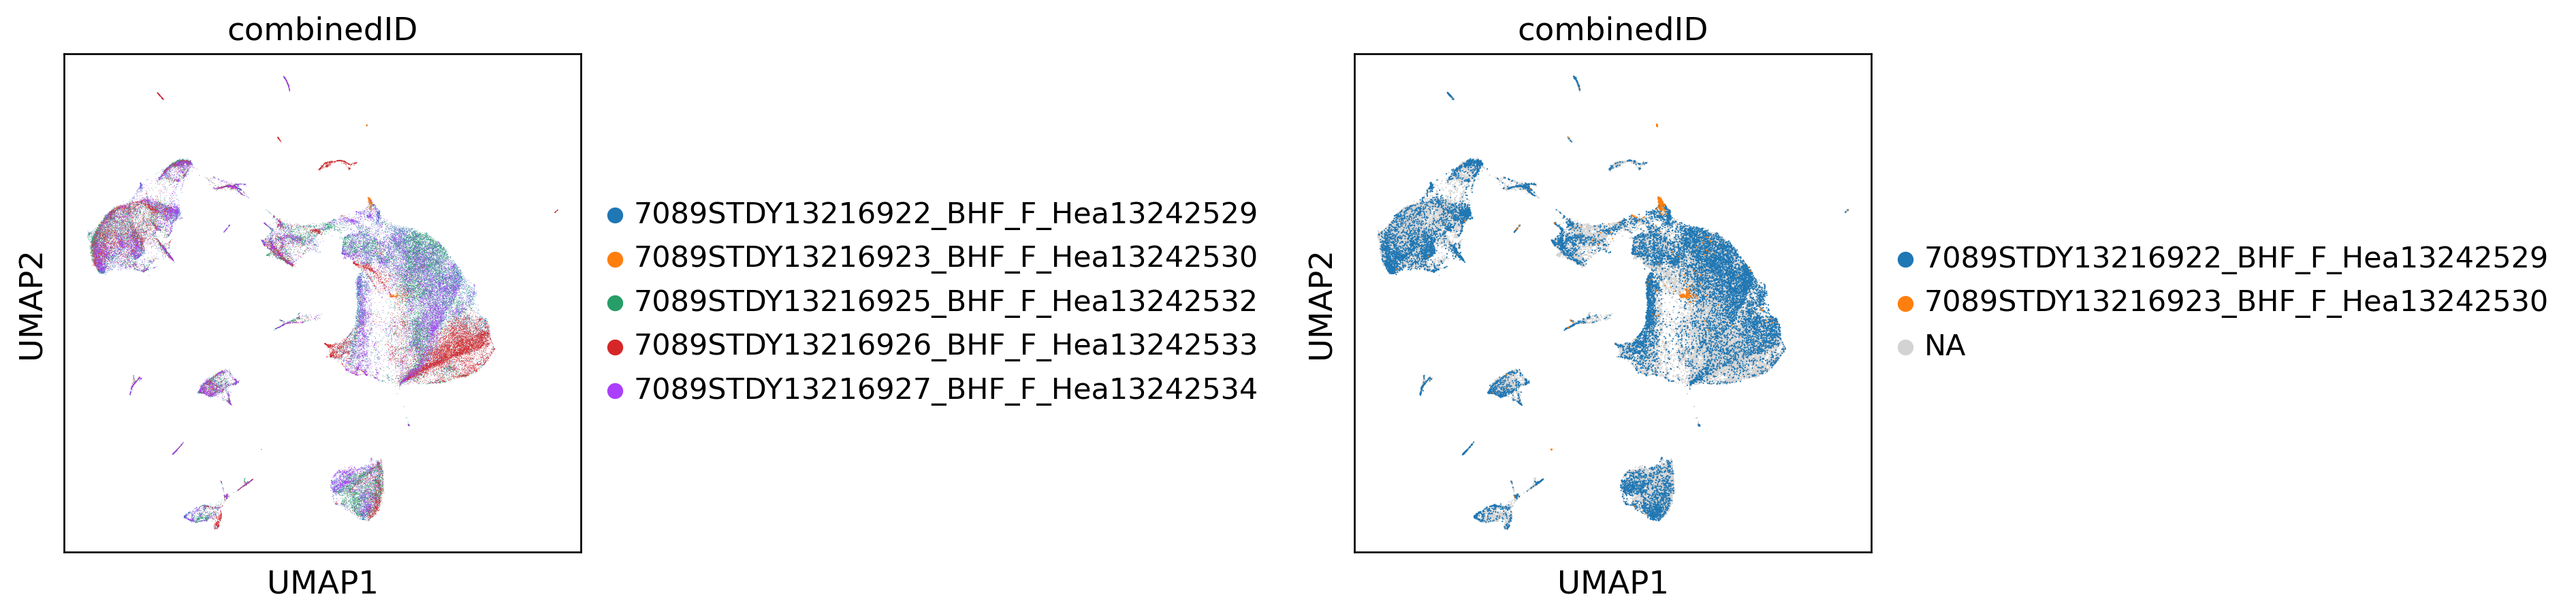

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,4)) 
sc.pl.umap(adata_test, color = ['combinedID',], show=False, ax=axs[0], size=0.3)
sc.pl.umap(adata_test, color = ['combinedID',], groups=['7089STDY13216922_BHF_F_Hea13242529','7089STDY13216923_BHF_F_Hea13242530'], show=False, ax=axs[1])
plt.tight_layout()

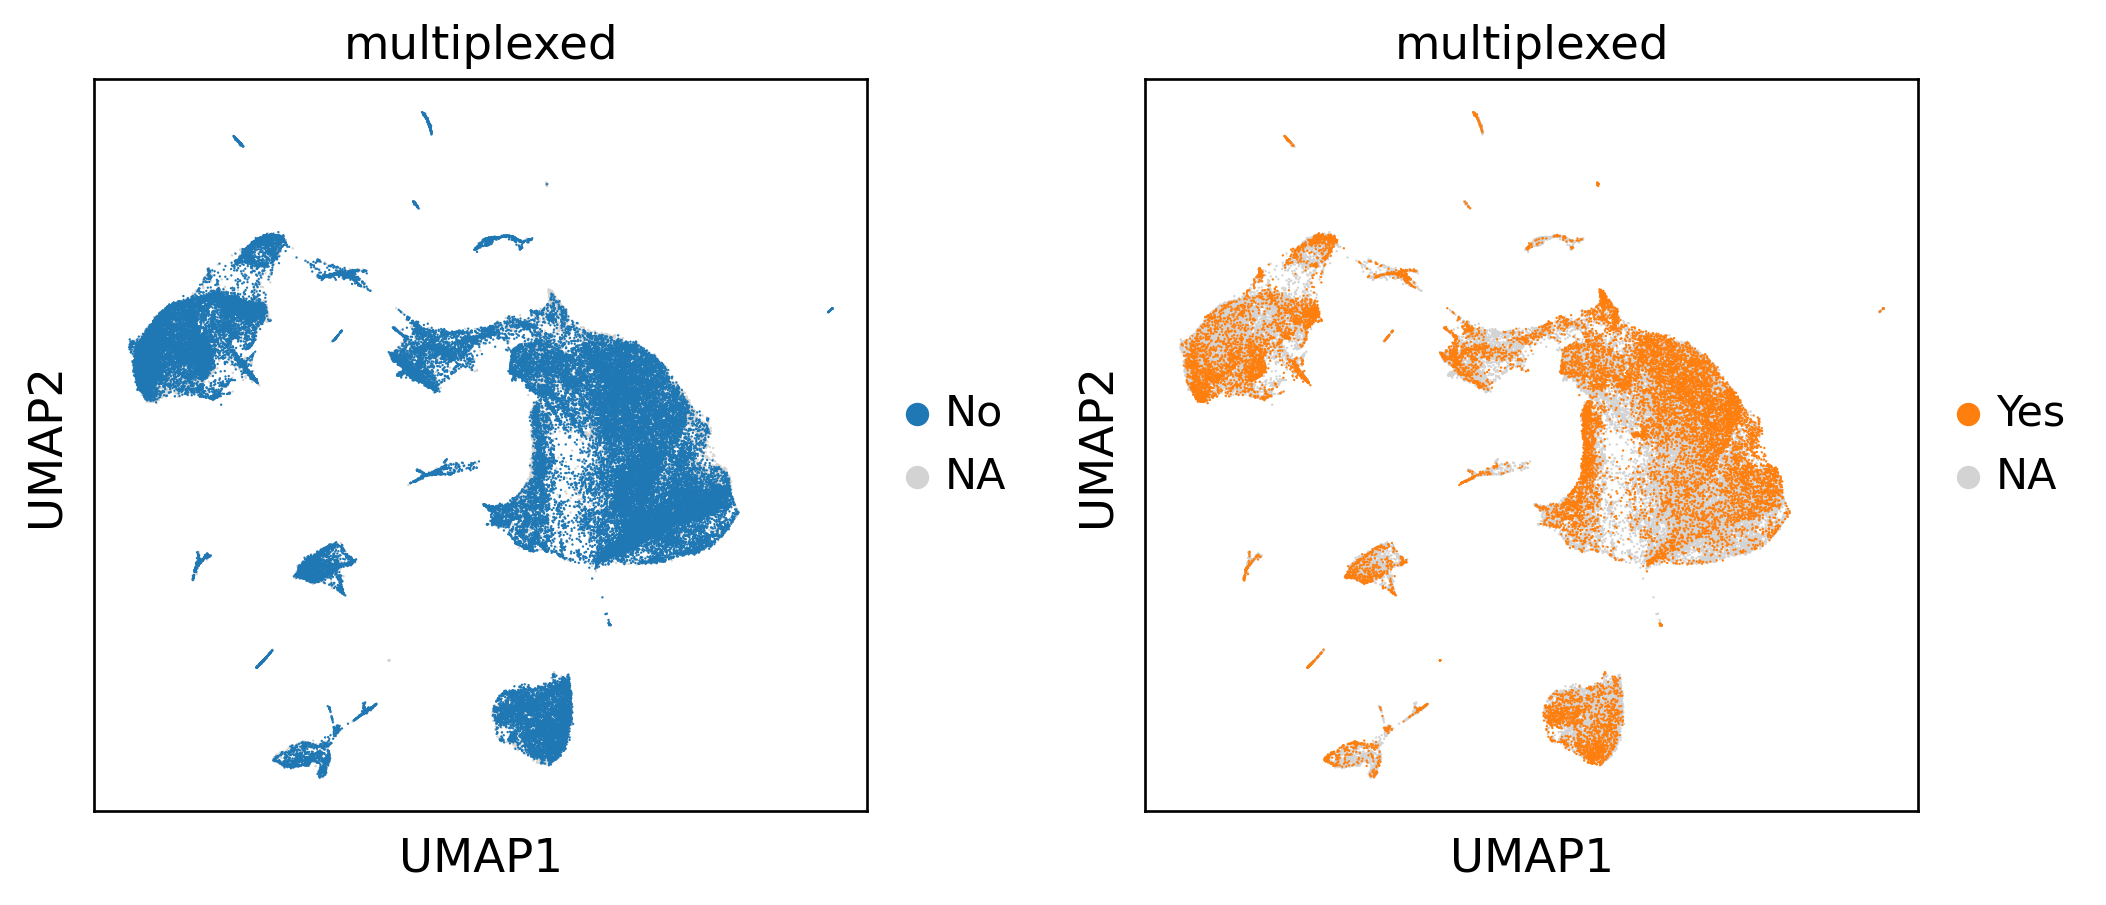

In [27]:
adata_test.obs['multiplexed'] = 'No'
multi_obsnames = adata_test.obs_names[adata_test.obs['combinedID'].isin(multiplexed_samples)]
adata_test.obs.loc[multi_obsnames,'multiplexed'] = 'Yes'

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9,4)) 
sc.pl.umap(adata_test, color = ['multiplexed'], groups='No', wspace=0.5, size=2, show=False, ax=axs[0])
sc.pl.umap(adata_test, color = ['multiplexed'], groups='Yes', wspace=0.5, size=2, show=False, ax=axs[1])
plt.tight_layout()

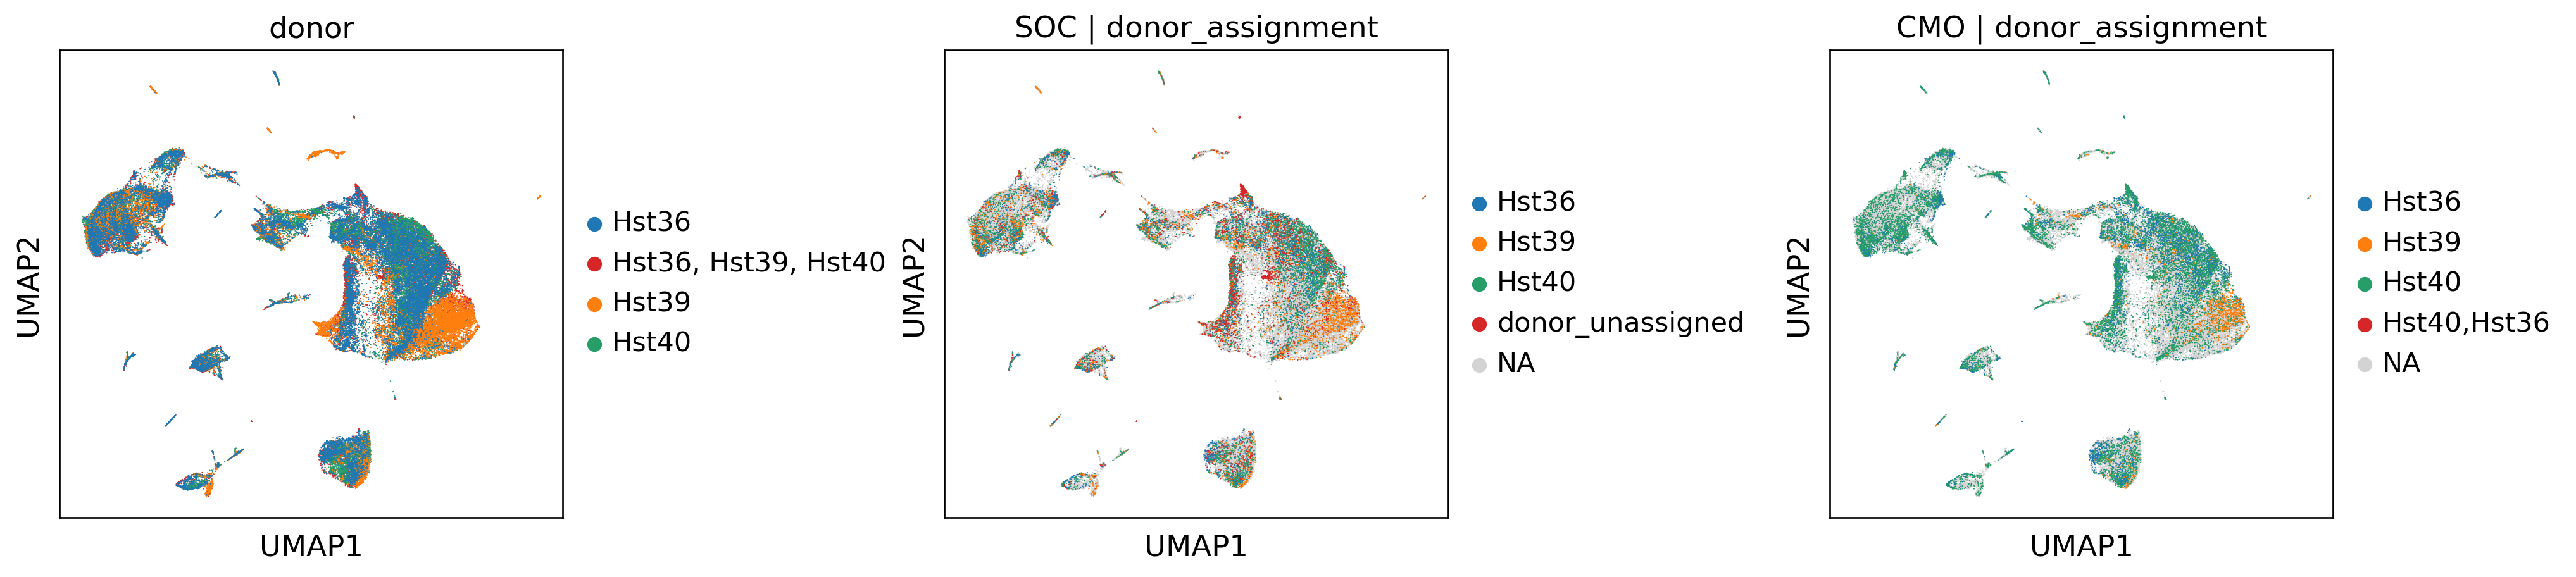

In [28]:
adata_test.uns['donor_colors'] = ['#1f77b4', '#d62728', '#ff7f0e', '#279e68']
sc.pl.umap(adata_test, color = ['donor','SOC | donor_assignment','CMO | donor_assignment',], wspace=0.6)

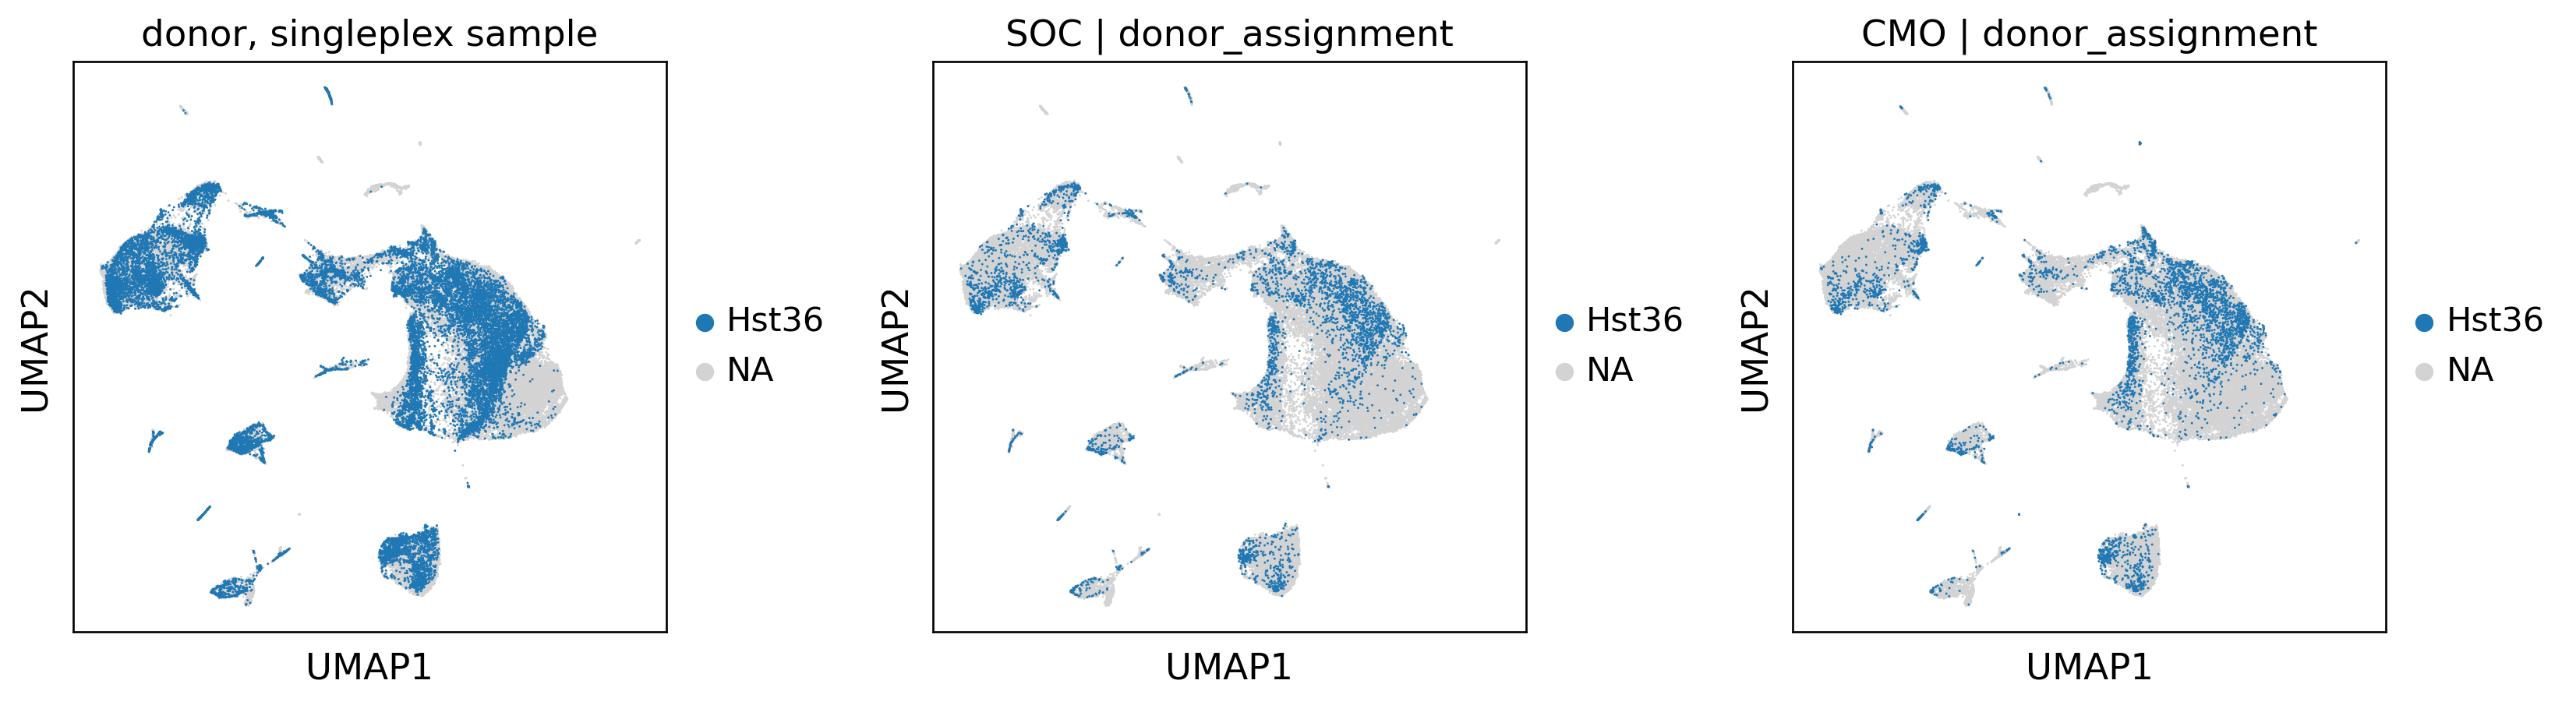

In [29]:
don = 'Hst36'
size = 3

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4)) 
sc.pl.umap(adata_test, color = ['donor'], groups=don, size=size, show=False, ax=axs[0], title='donor, singleplex sample')
sc.pl.umap(adata_test, color = ['SOC | donor_assignment'], groups=don, size=size, show=False, ax=axs[1])
sc.pl.umap(adata_test, color = ['CMO | donor_assignment'], groups=don, size=size, show=False, ax=axs[2])
plt.tight_layout()

--> similar patter between SOC and CMO

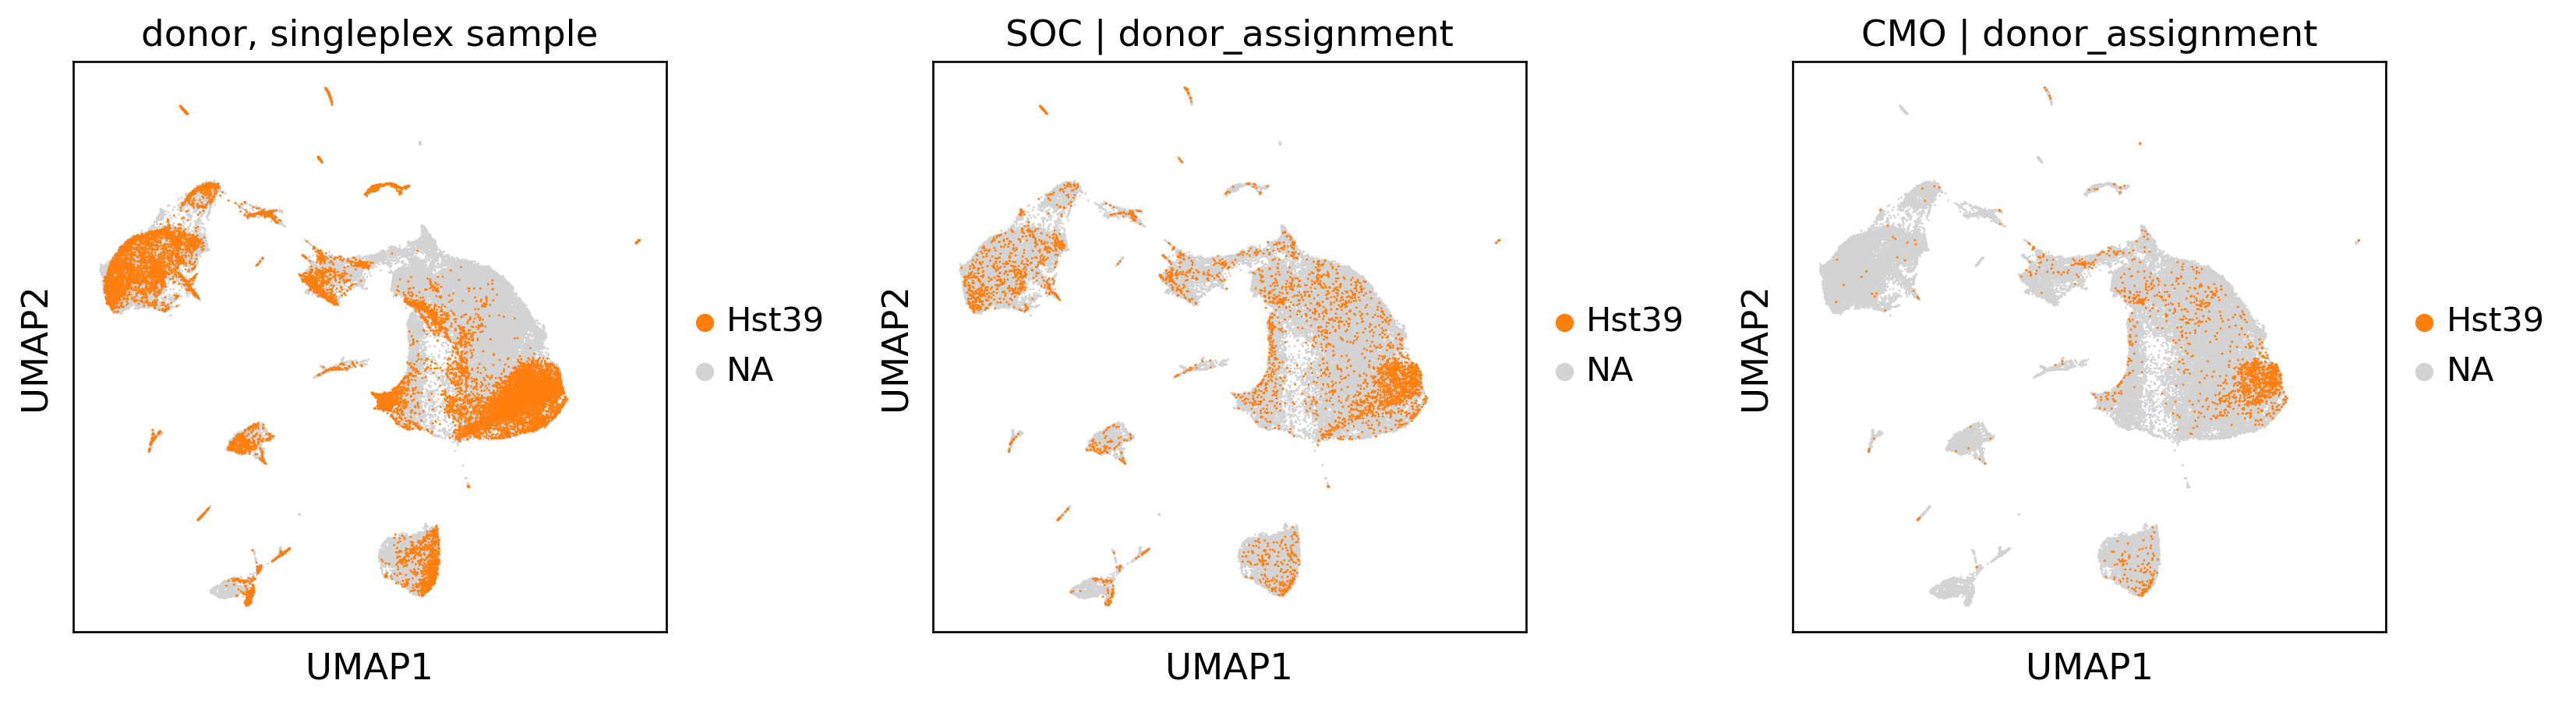

In [30]:
don = 'Hst39'
size = 3

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4)) 
sc.pl.umap(adata_test, color = ['donor'], groups=don, size=size, show=False, ax=axs[0], title='donor, singleplex sample')
sc.pl.umap(adata_test, color = ['SOC | donor_assignment'], groups=don, size=size, show=False, ax=axs[1])
sc.pl.umap(adata_test, color = ['CMO | donor_assignment'], groups=don, size=size, show=False, ax=axs[2])
plt.tight_layout()

--> CMO is lacking assignments in the left island

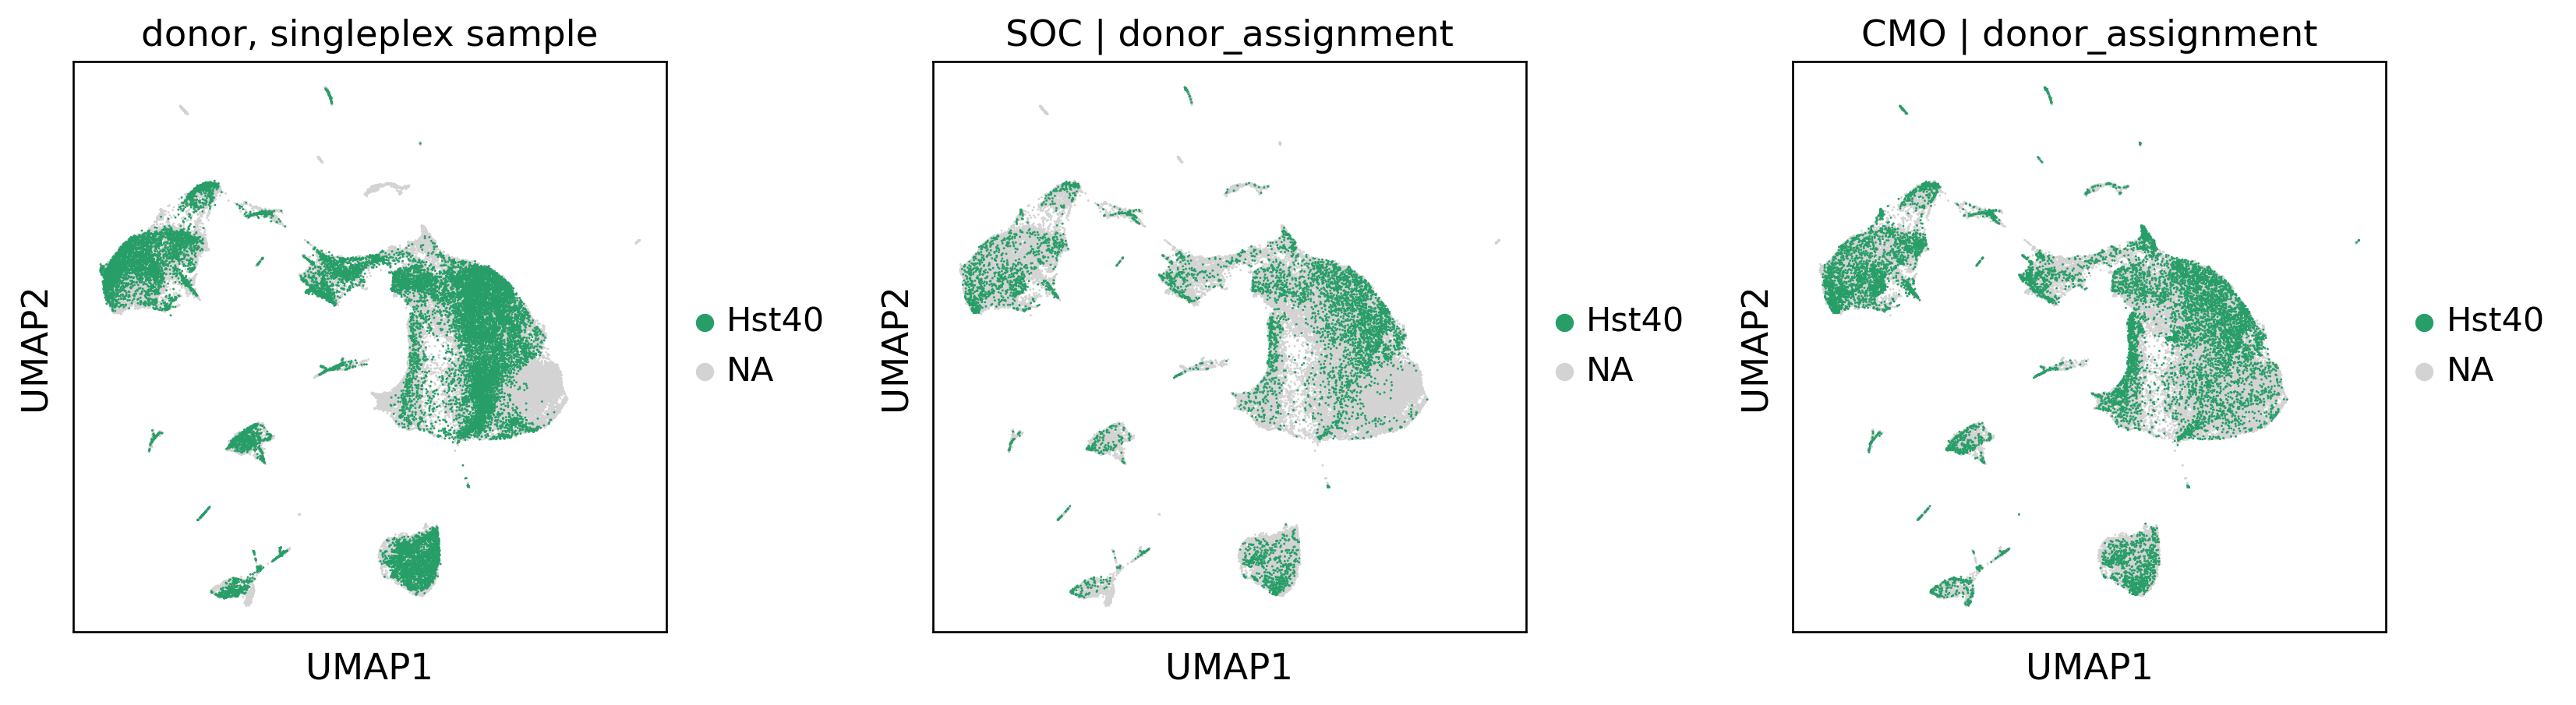

In [31]:
don = 'Hst40'
size = 3

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4)) 
sc.pl.umap(adata_test, color = ['donor'], groups=don, size=size, show=False, ax=axs[0], title='donor, singleplex sample')
sc.pl.umap(adata_test, color = ['SOC | donor_assignment'], groups=don, size=size, show=False, ax=axs[1])
sc.pl.umap(adata_test, color = ['CMO | donor_assignment'], groups=don, size=size, show=False, ax=axs[2])
plt.tight_layout()

--> CMO is over-assigning nuclei in the lower right part of the largest island

In [ ]:
sc.pl.umap(adata_test, color = ['CMO | prop_delta',], wspace=0.5)

# "CMO | ratio" of matched and unmatched nuclei

* "CMO | ratio": ratio of "the 1st maximum tag count" to "the 2nd maximum tag count" per cell

In [18]:
# multiplexed samples apart from '7089STDY13216923_BHF_F_Hea13242530'(no SOC assignment)
df = adata.obs[adata.obs['combinedID'].isin(['7089STDY13216920_BHF_F_Hea13242527',
                                             '7089STDY13216921_BHF_F_Hea13242528',
                                             '7089STDY13216922_BHF_F_Hea13242529',])]

pd.crosstab(df['SOC | donor_assignment'],df['CMO | donor_assignment'])

CMO | donor_assignment  Hst36  Hst39  Hst40  Hst40,Hst36  Hst40,Hst39
SOC | donor_assignment                                               
Hst36                    3559     73   1459            2            0
Hst39                     444  17144  18717            0           18
Hst40                     362    378  19505            0            1
donor_unassigned         1101   1475   8873            0            0

In [19]:
# new labels for the comparison
matched_obsnames = df.index[df['SOC | donor_assignment']==df['CMO | donor_assignment']]
unmatched_obsnames =  df.index[(df['SOC | donor_assignment']!=df['CMO | donor_assignment'])&(df['SOC | donor_assignment']!='donor_unassigned')]
unassigned_obsnames = df.index[df['SOC | status']=='unassigned']
doublet_obsnames = df.index[df['SOC | status']=='doublet']

df['match'] = np.nan
df.loc[matched_obsnames,'match'] = 'SOC-COM, matched'
df.loc[unmatched_obsnames,'match'] = 'SOC-COM, unmatched'
df.loc[unassigned_obsnames,'match'] = 'SOC status, unassigned'
df.loc[doublet_obsnames,'match'] = 'SOC status, doublet'
set(df['match'])

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


{'SOC status, doublet',
 'SOC status, unassigned',
 'SOC-COM, matched',
 'SOC-COM, unmatched'}

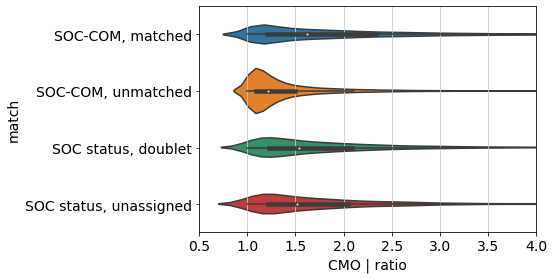

SOC-COM, matched          40208
SOC-COM, unmatched        21454
SOC status, doublet        8103
SOC status, unassigned     3346
Name: match, dtype: int64

In [20]:
sns.violinplot(data=df, x="CMO | ratio", y="match")
plt.xlim(0.5, 4)
plt.show()

df['match'].value_counts()

--> Unmatched samples has smaller "prop_delta" value, which suggest this metrics is usable for rescuing nuclei using CMO result (for those nuclei whose donor were not assigned by SOC)

## setting a threshold with matched and unmatched nuclei

In [21]:
from sklearn.metrics import roc_curve

In [22]:
df_s = df[df['match'].isin(['SOC-COM, matched','SOC-COM, unmatched'])]
X = np.array(df_s['CMO | ratio']) # .reshape(-1, 1)
y = np.array(df_s['match'] == 'SOC-COM, matched')

In [23]:
fpr,tpr,thresholds = roc_curve(y, X)
fpr,tpr,thresholds

(array([0.        , 0.        , 0.        , ..., 0.99888133, 0.99902116,
        1.        ]),
 array([0.00000000e+00, 2.48706725e-05, 1.09430959e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([15.5164995, 14.5164995,  8.282574 , ...,  1.0002261,  1.0001545,
         1.       ]))

### Option 1: to be max(tpr-fpr)

In [24]:
optimal_idx = np.argmax(tpr - fpr)
print(f'optimal threshold to make the "tpr - fpr" maximum: {thresholds[optimal_idx]}')
print(f'true positive rate with the threshold: {tpr[optimal_idx]}')
print(f'false positive rate with the threshold: {fpr[optimal_idx]}')

optimal threshold to make the "tpr - fpr" maximum: 1.4452686
true positive rate with the threshold: 0.5862763629128531
false positive rate with the threshold: 0.2780367297473665


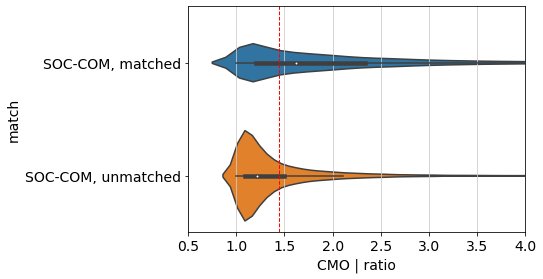

In [25]:
sns.violinplot(data=df_s, x="CMO | ratio", y="match")
plt.axvline(thresholds[optimal_idx], color='red', linestyle='dashed', linewidth=1)
plt.xlim(0.5, 4)
plt.show()
# red dashed line is the threshold which gives maximum "tpr - fpr" value

### Option 2: fpr lower than 0.05

In [26]:
optimal_idx = sum(fpr < 0.05)-1
print(f'optimal threshold to make the fpr lower than 0.05: {thresholds[optimal_idx]}')
print(f'true positive rate with the threshold: {tpr[optimal_idx]}')
print(f'false positive rate with the threshold: {fpr[optimal_idx]}')

optimal threshold to make the fpr lower than 0.05: 2.4282365
true positive rate with the threshold: 0.23104854755272583
false positive rate with the threshold: 0.049967372051831827


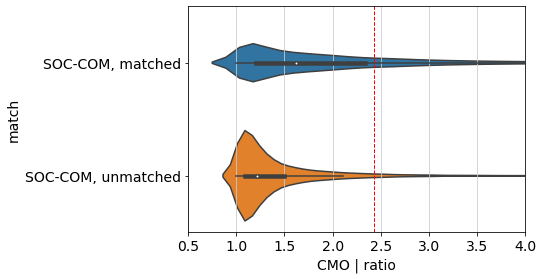

In [27]:
sns.violinplot(data=df_s, x="CMO | ratio", y="match")
plt.axvline(thresholds[optimal_idx], color='red', linestyle='dashed', linewidth=1)
plt.xlim(0.5, 4)
plt.show()
# red dashed line is the threshold which gives maximum "tpr - fpr" value

# Additional work

### Only SOC-assigned ones

In [ ]:
df = df['combinedID']==''

(61662, 35)


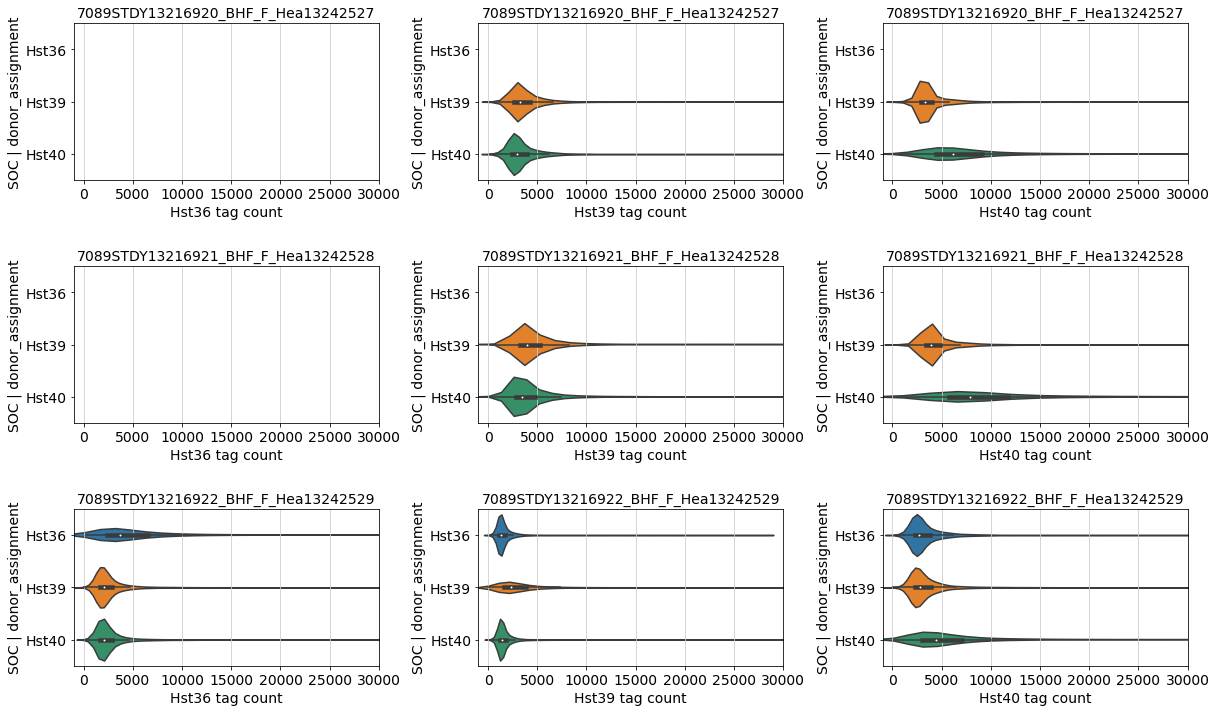

In [111]:
# multiplexed samples apart from '7089STDY13216923_BHF_F_Hea13242530'(no SOC assignment)
df = adata.obs[adata.obs['combinedID'].isin(['7089STDY13216920_BHF_F_Hea13242527',
                                             '7089STDY13216921_BHF_F_Hea13242528',
                                             '7089STDY13216922_BHF_F_Hea13242529',])]
# select only SOC | donor-assigned ones
df = df[df['SOC | donor_assignment'] != 'donor_unassigned']
print(df.shape)

donors = ['Hst36','Hst39','Hst40']
samples = ['7089STDY13216920_BHF_F_Hea13242527',
           '7089STDY13216921_BHF_F_Hea13242528',
           '7089STDY13216922_BHF_F_Hea13242529']
# set order
df['SOC | donor_assignment'] = df['SOC | donor_assignment'].astype('category')
df['SOC | donor_assignment'].cat.reorder_categories(donors, inplace=True)

fig,axs = plt.subplots(nrows=3, ncols=3, figsize=(17,10)) 
for sam in samples:
    df_s = df[df['combinedID']==sam]
    
    for don in donors:
        row_no = samples.index(sam)
        col_no = donors.index(don)
        
        sns.violinplot(data=df_s, 
                       x=f'CMO | {don}',
                       y=f'SOC | donor_assignment',
                       ax=axs[row_no,col_no])
        axs[row_no,col_no].set_xlabel(f'{don} tag count')
        axs[row_no,col_no].set_title(sam)
        axs[row_no,col_no].set_xlim(-1000, 30000)

plt.tight_layout(h_pad=3.0)

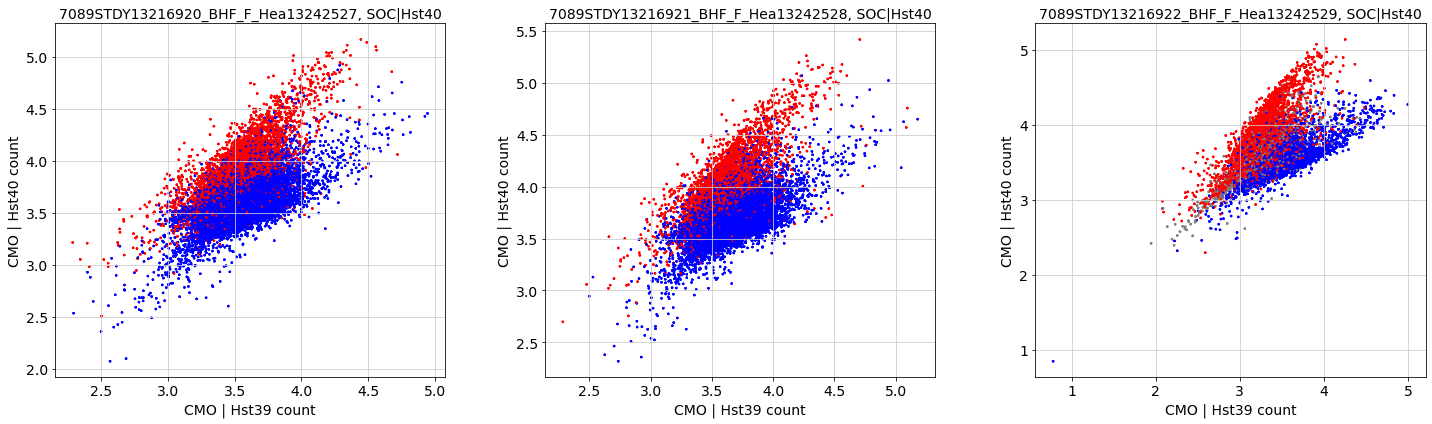

In [190]:
# multiplexed samples apart from '7089STDY13216923_BHF_F_Hea13242530'(no SOC assignment)
df = adata.obs[adata.obs['combinedID'].isin(['7089STDY13216920_BHF_F_Hea13242527',
                                             '7089STDY13216921_BHF_F_Hea13242528',
                                             '7089STDY13216922_BHF_F_Hea13242529',])]
# select only SOC | donor-assigned ones
df = df[df['SOC | donor_assignment'] != 'donor_unassigned']

# remove double-assigned nuclei
# df = df[[',' not in x for x in df['CMO | donor_assignment']]]
# print(df.shape)

donors = ['Hst36','Hst39','Hst40']
samples = ['7089STDY13216920_BHF_F_Hea13242527',
           '7089STDY13216921_BHF_F_Hea13242528',
           '7089STDY13216922_BHF_F_Hea13242529']

# set color
df['color'] = 'grey'
df.loc[df.index[df['SOC | donor_assignment']=='Hst39'],'color'] = 'blue'
df.loc[df.index[df['SOC | donor_assignment']=='Hst40'],'color'] = 'red'

# set order
# df['CMO | donor_assignment'] = df['CMO | donor_assignment'].astype('category')
# df['CMO | donor_assignment'].cat.reorder_categories(donors, inplace=True)

fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(20,6)) 

for sam in samples:
    # subset each sample
    df_s = df[df['combinedID']==sam]
    
    for don in donors:
        row_no = samples.index(sam)
        # col_no = donors.index(don)
        
        # subset each donor (assume SOC is giving the correct donor)
        # df_ss = df_s[df_s['SOC | donor_assignment']==don]
        
        axs[row_no].scatter( 
                       x=np.log10(df_s['CMO | Hst39']),
                       y=np.log10(df_s['CMO | Hst40']),
                       # x=df_s['CMO | Hst39'],
                       # y=df_s['CMO | Hst40'],
                       c=df_s['color'],
                        s=2
                       )
        axs[row_no].set_xlabel('CMO | Hst39 count')
        axs[row_no].set_ylabel('CMO | Hst40 count')
        axs[row_no].set_title(f'{sam}, SOC|{don}')
        # axs[row_no,col_no].set_xlim(-1000, 50000)

plt.tight_layout(w_pad=5.0, h_pad=3.0)

In [160]:
np.mean(df['CMO | Hst39'])

3688.686516817489

(61641, 37)


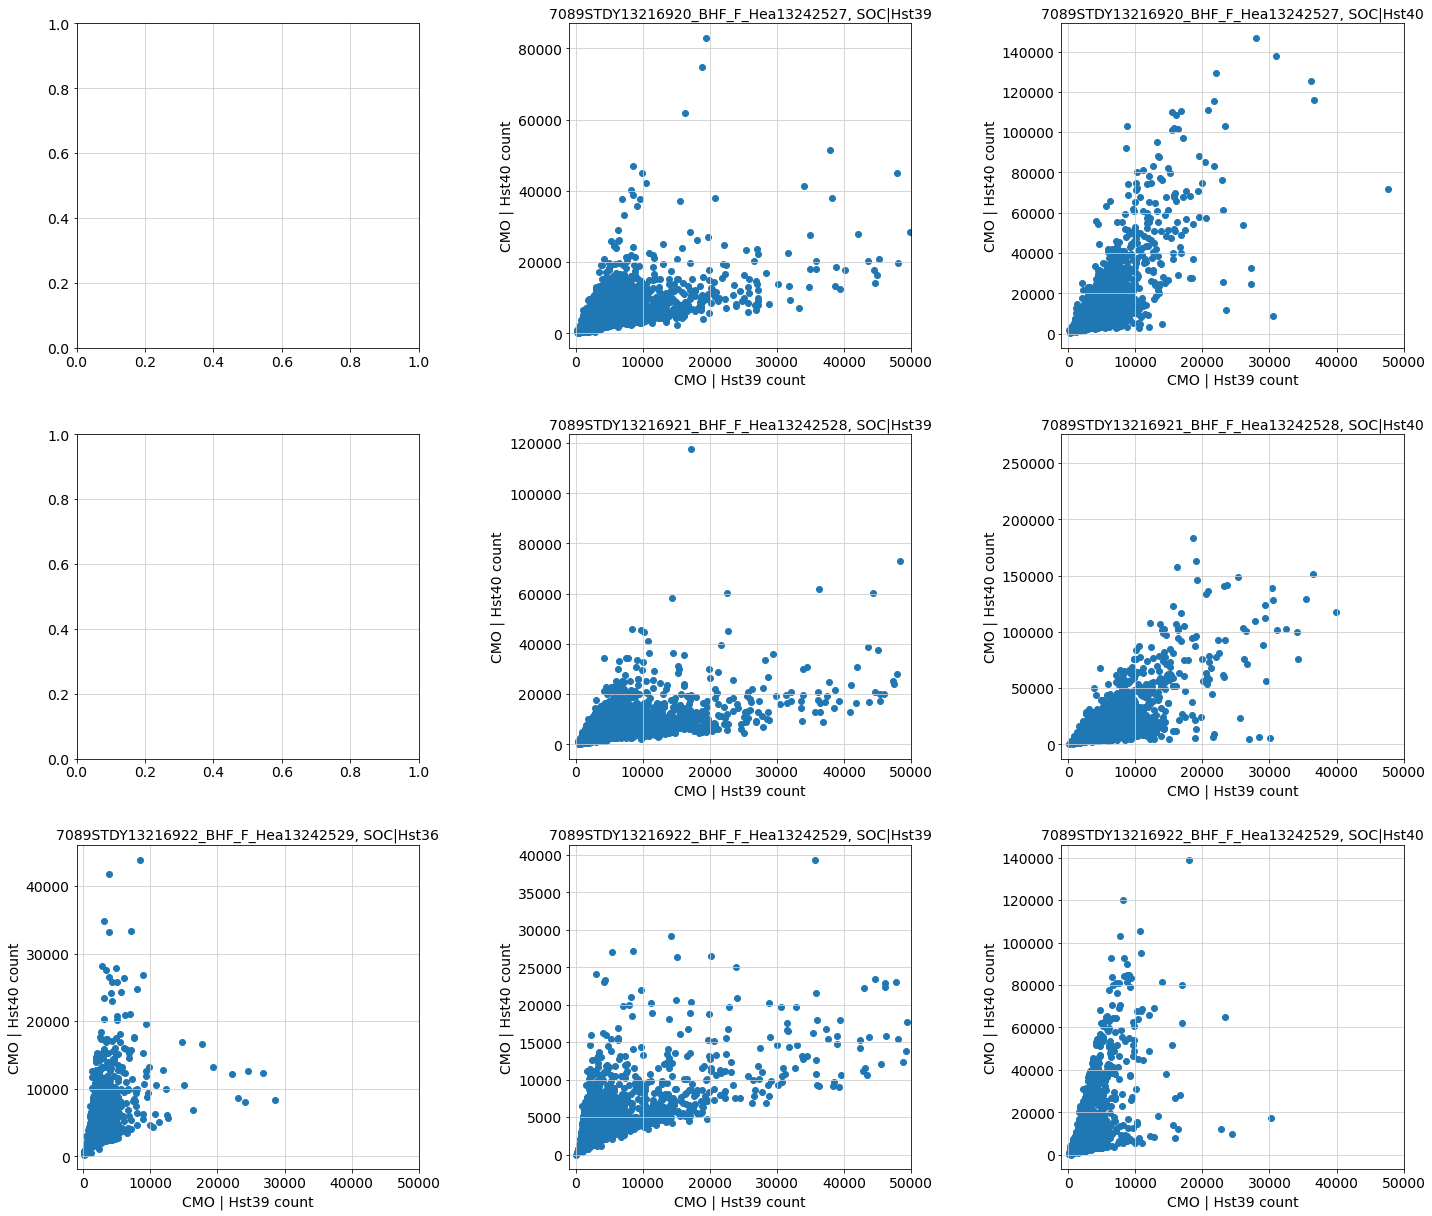

In [142]:
# multiplexed samples apart from '7089STDY13216923_BHF_F_Hea13242530'(no SOC assignment)
df = adata.obs[adata.obs['combinedID'].isin(['7089STDY13216920_BHF_F_Hea13242527',
                                             '7089STDY13216921_BHF_F_Hea13242528',
                                             '7089STDY13216922_BHF_F_Hea13242529',])]
# select only SOC | donor-assigned ones
df = df[df['SOC | donor_assignment'] != 'donor_unassigned']

# remove double-assigned nuclei
df = df[[',' not in x for x in df['CMO | donor_assignment']]]
print(df.shape)

donors = ['Hst36','Hst39','Hst40']
samples = ['7089STDY13216920_BHF_F_Hea13242527',
           '7089STDY13216921_BHF_F_Hea13242528',
           '7089STDY13216922_BHF_F_Hea13242529']

# set order
df['CMO | donor_assignment'] = df['CMO | donor_assignment'].astype('category')
df['CMO | donor_assignment'].cat.reorder_categories(donors, inplace=True)

fig,axs = plt.subplots(nrows=3, ncols=3, figsize=(20,17)) 

for sam in samples:
    # subset each sample
    df_s = df[df['combinedID']==sam]
    
    for don in donors:
        row_no = samples.index(sam)
        col_no = donors.index(don)
        
        # subset each donor (assume SOC is giving the correct donor)
        df_ss = df_s[df_s['SOC | donor_assignment']==don]
        
        if len(df_ss)==0:
            continue
        
        axs[row_no,col_no].scatter(data=df_ss, 
                       x='CMO | Hst39',
                       y='CMO | Hst40',
                       )
        axs[row_no,col_no].set_xlabel('CMO | Hst39 count')
        axs[row_no,col_no].set_ylabel('CMO | Hst40 count')
        axs[row_no,col_no].set_title(f'{sam}, SOC|{don}')
        axs[row_no,col_no].set_xlim(-1000, 50000)

plt.tight_layout(w_pad=5.0, h_pad=3.0)

In [163]:
samplefile = pd.read_csv('/nfs/team205/heart/mapped/CMO/csv/multiome-foetal_20221221.csv')
samplefile.set_index('CMO_ID',inplace=True)
samplefile

Multiome_ID  \
CMO_ID                                                 
7089STDY13216916  7089STDY13216920_BHF_F_Hea13242527   
7089STDY13216917  7089STDY13216921_BHF_F_Hea13242528   
7089STDY13216918  7089STDY13216922_BHF_F_Hea13242529   
7089STDY13216919  7089STDY13216923_BHF_F_Hea13242530   

                                                                                                      Mapping_iRODS  
CMO_ID                                                                                                               
7089STDY13216916    /seq/illumina/runs/46/46301/cellranger/cellranger700_count_46301_7089STDY13216916_GRCh38-2020-A  
7089STDY13216917    /seq/illumina/runs/46/46301/cellranger/cellranger700_count_46301_7089STDY13216917_GRCh38-2020-A  
7089STDY13216918    /seq/illumina/runs/46/46301/cellranger/cellranger700_count_46301_7089STDY13216918_GRCh38-2020-A  
7089STDY13216919  /seq/illumina/runs/46/46301/cellranger/cellranger700_count_46301_7089STDY13216919_GRCh38-2020-A\t

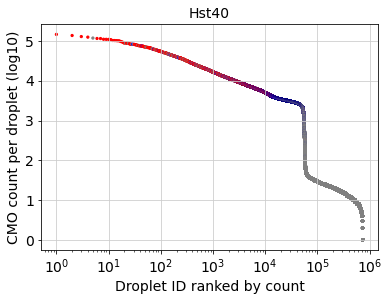

<Figure size 432x288 with 0 Axes>

In [174]:
cmo_ID = '7089STDY13216916'
cmo_raw = sc.read_10x_mtx(f'/nfs/team205/heart/mapped/CMO/{cmo_ID}/raw_feature_bc_matrix',
                     gex_only=False)
cmo_raw.var_names = [x.split('-')[0] for x in cmo_raw.var_names]


# get multiome ID
multi_ID = samplefile.loc[cmo_ID,'Multiome_ID']

# modify obs_names
cmo_raw.obs_names = multi_ID + '_' + cmo_raw.obs_names

# label
cmo_raw.obs['label'] = 'not-cell'
shared = set(adata.obs_names).intersection(cmo_raw.obs_names)
cmo_raw.obs.loc[shared,'label'] = adata.obs.loc[shared, 'SOC | donor_assignment']

# color
cmo_raw.obs['color'] = cmo_raw.obs['label'].copy()
cmo_raw.obs.replace({'color':{
    'Hst36':'green',
    'Hst39':'blue',
    'Hst40':'red',
    'donor_unassigned':'grey',
    'not-cell':'grey'
}},inplace=True)

tag = 'Hst40'
df = cmo_raw.to_df()[[tag]]
df.sort_values(tag,ascending=False,inplace=True)
df['rank'] = np.array(range(len(df)))+1

plt.rcParams['figure.figsize'] = 6,4
plt.scatter(x=df['rank'], y=np.log10(df[tag]), c=cmo_raw.obs['color'].reindex(df.index), s=5)
# plt.scatter(x=df['rank'], y=df[tag], c=cmo_raw.obs['color'].reindex(df.index), s=5)
plt.xscale('log')
plt.xlabel('Droplet ID ranked by count')
plt.ylabel(f'CMO count per droplet (log10)')
plt.title(tag)
plt.show()
plt.clf()

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


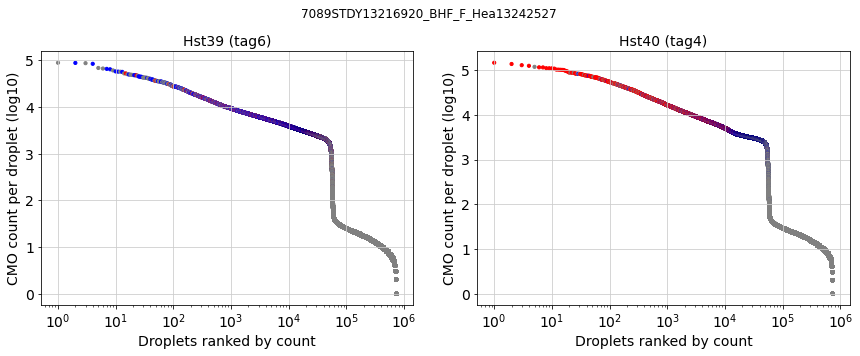

In [187]:
cmo_ID = '7089STDY13216916'
cmo_raw = sc.read_10x_mtx(f'/nfs/team205/heart/mapped/CMO/{cmo_ID}/raw_feature_bc_matrix',
                     gex_only=False)
cmo_raw.var_names = [x.split('-')[0] for x in cmo_raw.var_names]


# get multiome ID
multi_ID = samplefile.loc[cmo_ID,'Multiome_ID']

# modify obs_names
cmo_raw.obs_names = multi_ID + '_' + cmo_raw.obs_names

# label
cmo_raw.obs['label'] = 'not-cell'
shared = set(adata.obs_names).intersection(cmo_raw.obs_names)
cmo_raw.obs.loc[shared,'label'] = adata.obs.loc[shared, 'SOC | donor_assignment']

# color
cmo_raw.obs['color'] = cmo_raw.obs['label'].copy()
cmo_raw.obs.replace({'color':{
    'Hst36':'green',
    'Hst39':'blue',
    'Hst40':'red',
    'donor_unassigned':'grey',
    'not-cell':'grey'
}},inplace=True)

tags = ['Hst39 (tag6)', 'Hst40 (tag4)']

fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.suptitle(multi_ID)
for i,tg in enumerate(tags):
    don = tg.split(' (')[0]
    df = cmo_raw.to_df()[[don]]
    df.sort_values(don,ascending=False,inplace=True)
    df['rank'] = np.array(range(len(df)))+1

    axs[i].scatter(x=df['rank'], y=np.log10(df[don]), c=cmo_raw.obs['color'].reindex(df.index), s=10)
    # axs[i].scatter(x=df['rank'], y=df[don], c=cmo_raw.obs['color'].reindex(df.index), s=1)
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Droplets ranked by count')
    axs[i].set_ylabel(f'CMO count per droplet (log10)')
    axs[i].set_title(tg)

plt.tight_layout(w_pad=3.0)

In [185]:
cmo_raw.to_df()

gene_ids     feature_types
Hst40  Hst40-HEA-0-FO-2  Antibody Capture
Hst39  Hst39-HEA-0-FO-3  Antibody Capture
Hst36  Hst36-HEA-0-FO-1  Antibody Capture

In [ ]:
'label'

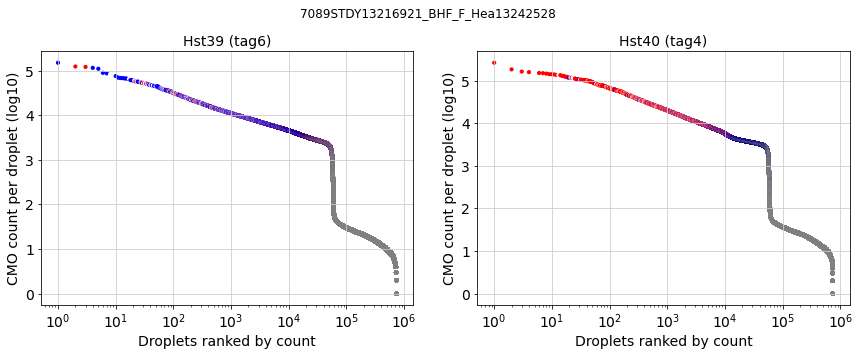

In [191]:
cmo_ID = '7089STDY13216917'
cmo_raw = sc.read_10x_mtx(f'/nfs/team205/heart/mapped/CMO/{cmo_ID}/raw_feature_bc_matrix',
                     gex_only=False)
cmo_raw.var_names = [x.split('-')[0] for x in cmo_raw.var_names]


# get multiome ID
multi_ID = samplefile.loc[cmo_ID,'Multiome_ID']

# modify obs_names
cmo_raw.obs_names = multi_ID + '_' + cmo_raw.obs_names

# label
cmo_raw.obs['label'] = 'not-cell'
shared = set(adata.obs_names).intersection(cmo_raw.obs_names)
cmo_raw.obs.loc[shared,'label'] = adata.obs.loc[shared, 'SOC | donor_assignment']

# color
cmo_raw.obs['color'] = cmo_raw.obs['label'].copy()
cmo_raw.obs.replace({'color':{
    'Hst36':'green',
    'Hst39':'blue',
    'Hst40':'red',
    'donor_unassigned':'white',
    'not-cell':'grey'
}},inplace=True)

tags = ['Hst39 (tag6)', 'Hst40 (tag4)']

fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.suptitle(multi_ID)
for i,tg in enumerate(tags):
    don = tg.split(' (')[0]
    df = cmo_raw.to_df()[[don]]
    df.sort_values(don,ascending=False,inplace=True)
    df['rank'] = np.array(range(len(df)))+1

    axs[i].scatter(x=df['rank'], y=np.log10(df[don]), c=cmo_raw.obs['color'].reindex(df.index), s=10)
    # axs[i].scatter(x=df['rank'], y=df[don], c=cmo_raw.obs['color'].reindex(df.index), s=1)
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Droplets ranked by count')
    axs[i].set_ylabel(f'CMO count per droplet (log10)')
    axs[i].set_title(tg)

plt.tight_layout(w_pad=3.0)

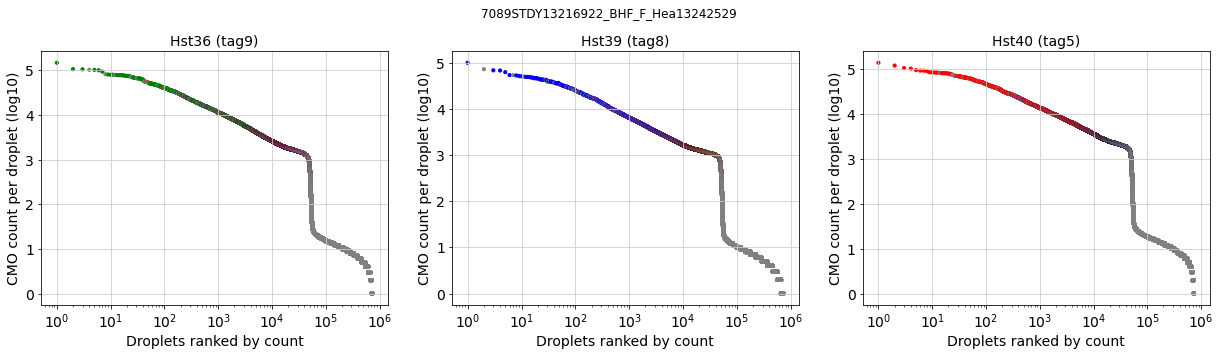

In [189]:
cmo_ID = '7089STDY13216918'
cmo_raw = sc.read_10x_mtx(f'/nfs/team205/heart/mapped/CMO/{cmo_ID}/raw_feature_bc_matrix',
                     gex_only=False)
cmo_raw.var_names = [x.split('-')[0] for x in cmo_raw.var_names]


# get multiome ID
multi_ID = samplefile.loc[cmo_ID,'Multiome_ID']

# modify obs_names
cmo_raw.obs_names = multi_ID + '_' + cmo_raw.obs_names

# label
cmo_raw.obs['label'] = 'not-cell'
shared = set(adata.obs_names).intersection(cmo_raw.obs_names)
cmo_raw.obs.loc[shared,'label'] = adata.obs.loc[shared, 'SOC | donor_assignment']

# color
cmo_raw.obs['color'] = cmo_raw.obs['label'].copy()
cmo_raw.obs.replace({'color':{
    'Hst36':'green',
    'Hst39':'blue',
    'Hst40':'red',
    'donor_unassigned':'grey',
    'not-cell':'grey'
}},inplace=True)

tags = ['Hst36 (tag9)', 'Hst39 (tag8)', 'Hst40 (tag5)']

fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
fig.suptitle(multi_ID)
for i,tg in enumerate(tags):
    don = tg.split(' (')[0]
    df = cmo_raw.to_df()[[don]]
    df.sort_values(don,ascending=False,inplace=True)
    df['rank'] = np.array(range(len(df)))+1

    axs[i].scatter(x=df['rank'], y=np.log10(df[don]), c=cmo_raw.obs['color'].reindex(df.index), s=10)
    # axs[i].scatter(x=df['rank'], y=df[don], c=cmo_raw.obs['color'].reindex(df.index), s=1)
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Droplets ranked by count')
    axs[i].set_ylabel(f'CMO count per droplet (log10)')
    axs[i].set_title(tg)

plt.tight_layout(w_pad=3.0)

(61641, 37)


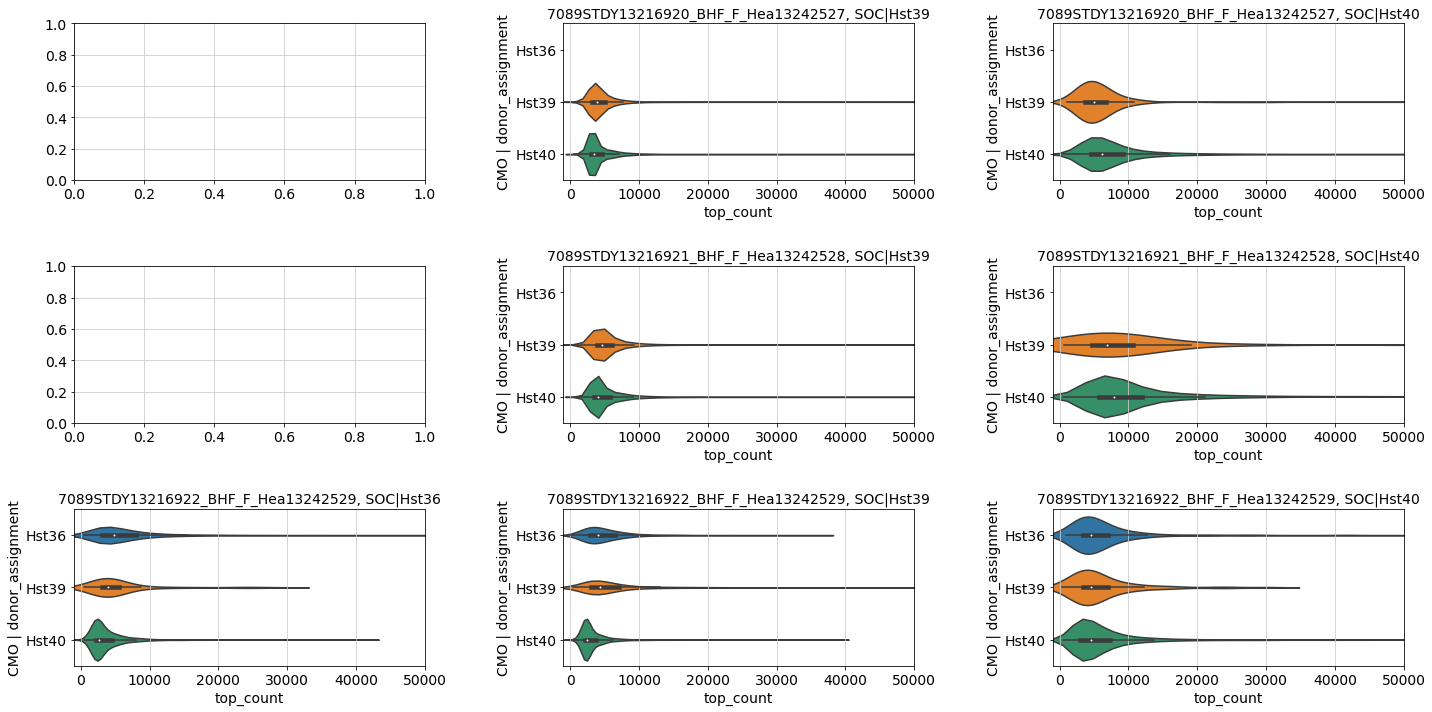

In [135]:
# multiplexed samples apart from '7089STDY13216923_BHF_F_Hea13242530'(no SOC assignment)
df = adata.obs[adata.obs['combinedID'].isin(['7089STDY13216920_BHF_F_Hea13242527',
                                             '7089STDY13216921_BHF_F_Hea13242528',
                                             '7089STDY13216922_BHF_F_Hea13242529',])]
# select only SOC | donor-assigned ones
df = df[df['SOC | donor_assignment'] != 'donor_unassigned']

# remove double-assigned nuclei
df = df[[',' not in x for x in df['CMO | donor_assignment']]]
print(df.shape)

donors = ['Hst36','Hst39','Hst40']
samples = ['7089STDY13216920_BHF_F_Hea13242527',
           '7089STDY13216921_BHF_F_Hea13242528',
           '7089STDY13216922_BHF_F_Hea13242529']

# set order
df['CMO | donor_assignment'] = df['CMO | donor_assignment'].astype('category')
df['CMO | donor_assignment'].cat.reorder_categories(donors, inplace=True)

fig,axs = plt.subplots(nrows=3, ncols=3, figsize=(20,10)) 

for sam in samples:
    # subset each sample
    df_s = df[df['combinedID']==sam]
    
    for don in donors:
        row_no = samples.index(sam)
        col_no = donors.index(don)
        
        # subset each donor (assume SOC is giving the correct donor)
        df_ss = df_s[df_s['SOC | donor_assignment']==don]
        
        if len(df_ss)==0:
            continue
        
        sns.violinplot(data=df_ss, 
                       x=f'CMO | top_count',
                       y=f'CMO | donor_assignment',
                       ax=axs[row_no,col_no])
        axs[row_no,col_no].set_xlabel(f'top_count')
        axs[row_no,col_no].set_title(f'{sam}, SOC|{don}')
        axs[row_no,col_no].set_xlim(-1000, 50000)

plt.tight_layout(w_pad=5.0, h_pad=3.0)

(61641, 36)


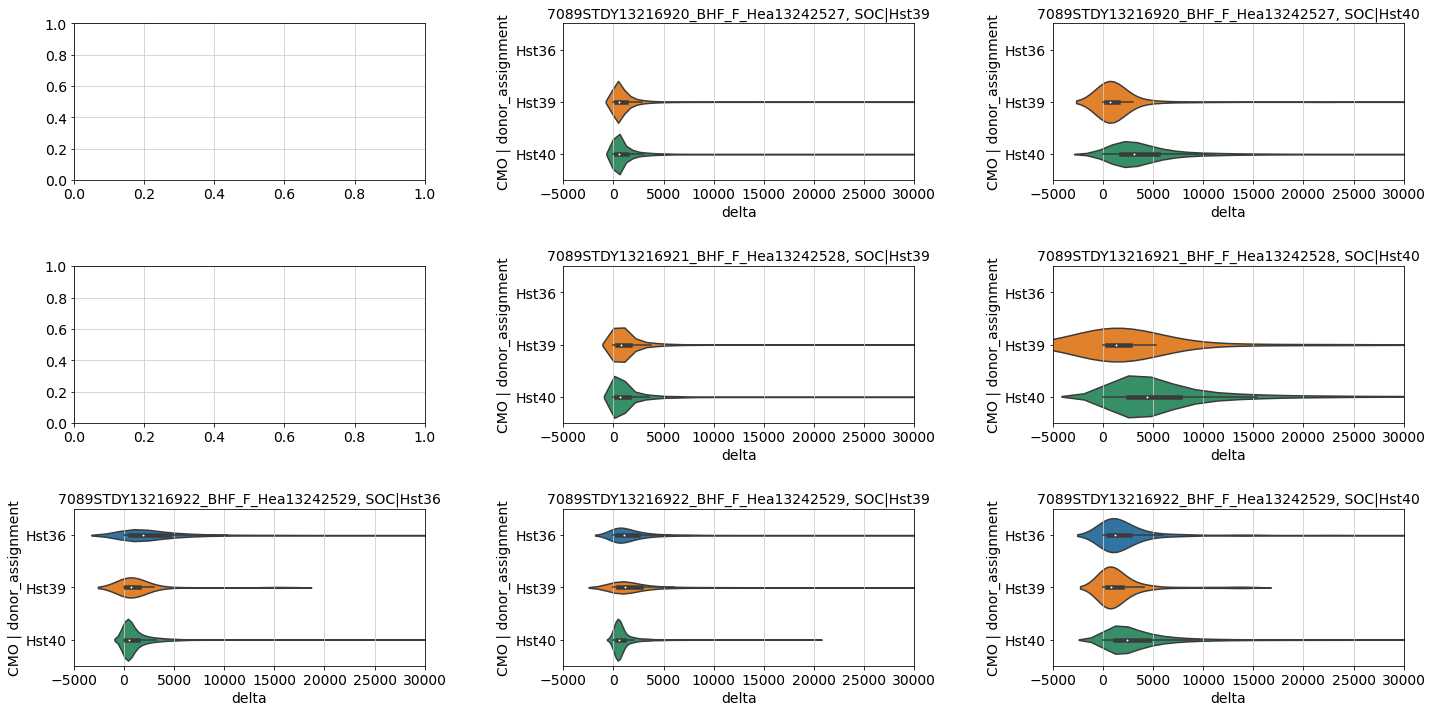

In [126]:
# multiplexed samples apart from '7089STDY13216923_BHF_F_Hea13242530'(no SOC assignment)
df = adata.obs[adata.obs['combinedID'].isin(['7089STDY13216920_BHF_F_Hea13242527',
                                             '7089STDY13216921_BHF_F_Hea13242528',
                                             '7089STDY13216922_BHF_F_Hea13242529',])]
# select only SOC | donor-assigned ones
df = df[df['SOC | donor_assignment'] != 'donor_unassigned']

# remove double-assigned nuclei
df = df[[',' not in x for x in df['CMO | donor_assignment']]]
print(df.shape)

donors = ['Hst36','Hst39','Hst40']
samples = ['7089STDY13216920_BHF_F_Hea13242527',
           '7089STDY13216921_BHF_F_Hea13242528',
           '7089STDY13216922_BHF_F_Hea13242529']

# set order
df['CMO | donor_assignment'] = df['CMO | donor_assignment'].astype('category')
df['CMO | donor_assignment'].cat.reorder_categories(donors, inplace=True)

fig,axs = plt.subplots(nrows=3, ncols=3, figsize=(20,10)) 

for sam in samples:
    # subset each sample
    df_s = df[df['combinedID']==sam]
    
    for don in donors:
        row_no = samples.index(sam)
        col_no = donors.index(don)
        
        # subset each donor (assume SOC is giving the correct donor)
        df_ss = df_s[df_s['SOC | donor_assignment']==don]
        
        if len(df_ss)==0:
            continue
        
        sns.violinplot(data=df_ss, 
                       x=f'CMO | delta',
                       y=f'CMO | donor_assignment',
                       ax=axs[row_no,col_no])
        axs[row_no,col_no].set_xlabel(f'delta')
        axs[row_no,col_no].set_title(f'{sam}, SOC|{don}')
        axs[row_no,col_no].set_xlim(-5000, 30000)

plt.tight_layout(w_pad=5.0, h_pad=3.0)

In [130]:
np.mean(df['CMO | Hst39'])

3688.8545935335246

(61641, 35)


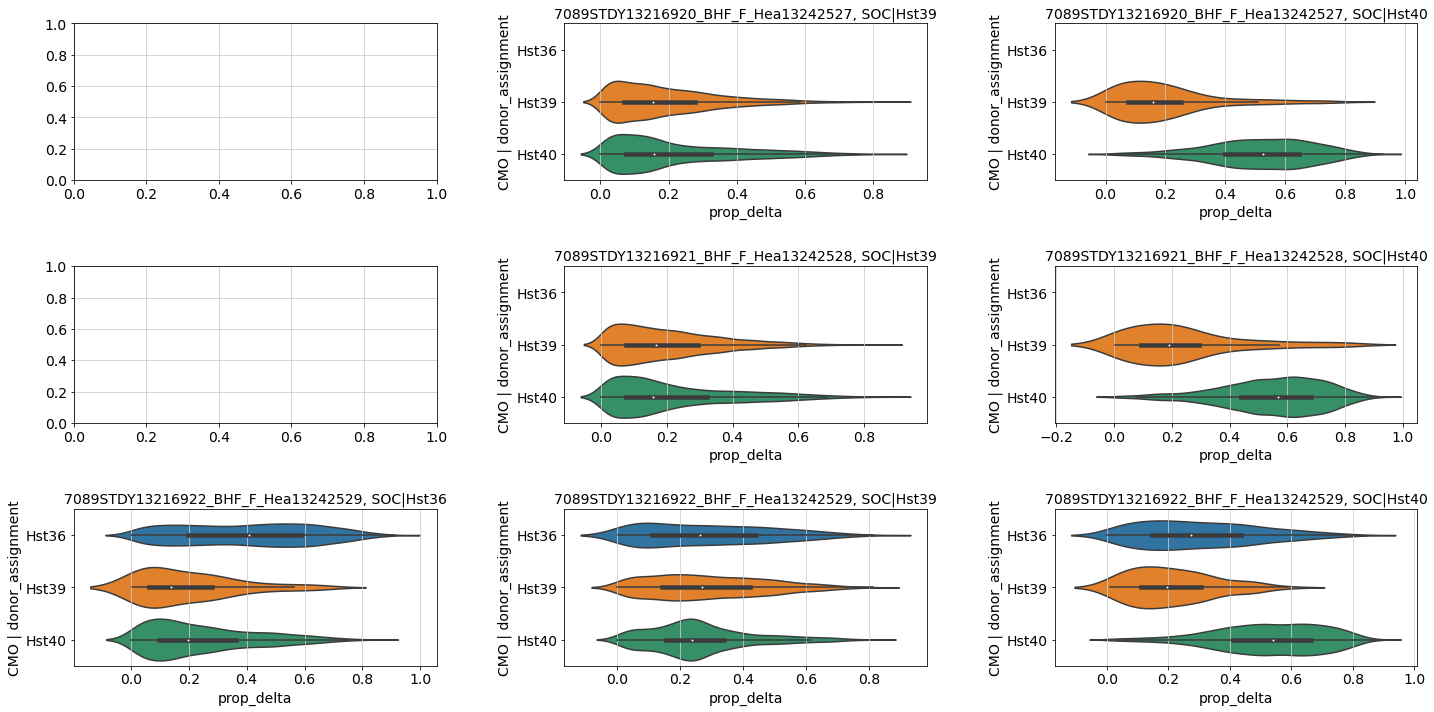

In [120]:
# multiplexed samples apart from '7089STDY13216923_BHF_F_Hea13242530'(no SOC assignment)
df = adata.obs[adata.obs['combinedID'].isin(['7089STDY13216920_BHF_F_Hea13242527',
                                             '7089STDY13216921_BHF_F_Hea13242528',
                                             '7089STDY13216922_BHF_F_Hea13242529',])]
# select only SOC | donor-assigned ones
df = df[df['SOC | donor_assignment'] != 'donor_unassigned']

# remove double-assigned nuclei
df = df[[',' not in x for x in df['CMO | donor_assignment']]]
print(df.shape)

donors = ['Hst36','Hst39','Hst40']
samples = ['7089STDY13216920_BHF_F_Hea13242527',
           '7089STDY13216921_BHF_F_Hea13242528',
           '7089STDY13216922_BHF_F_Hea13242529']

# set order
df['CMO | donor_assignment'] = df['CMO | donor_assignment'].astype('category')
df['CMO | donor_assignment'].cat.reorder_categories(donors, inplace=True)

fig,axs = plt.subplots(nrows=3, ncols=3, figsize=(20,10)) 

for sam in samples:
    # subset each sample
    df_s = df[df['combinedID']==sam]
    
    for don in donors:
        row_no = samples.index(sam)
        col_no = donors.index(don)
        
        # subset each donor (assume SOC is giving the correct donor)
        df_ss = df_s[df_s['SOC | donor_assignment']==don]
        
        if len(df_ss)==0:
            continue
        
        sns.violinplot(data=df_ss, 
                       x=f'CMO | prop_delta',
                       y=f'CMO | donor_assignment',
                       ax=axs[row_no,col_no])
        axs[row_no,col_no].set_xlabel(f'prop_delta')
        axs[row_no,col_no].set_title(f'{sam}, SOC|{don}')

plt.tight_layout(w_pad=5.0, h_pad=3.0)

In [ ]:
# multiplexed samples apart from '7089STDY13216923_BHF_F_Hea13242530'(no SOC assignment)
df = adata.obs[adata.obs['combinedID'].isin(['7089STDY13216920_BHF_F_Hea13242527',
                                             '7089STDY13216921_BHF_F_Hea13242528',
                                             '7089STDY13216922_BHF_F_Hea13242529',])]
# select only SOC | donor-assigned ones
df = df[df['SOC | donor_assignment'] != 'donor_unassigned']

# remove double-assigned nuclei
df = df[[',' not in x for x in df['CMO | donor_assignment']]]
print(df.shape)

donors = ['Hst36','Hst39','Hst40']
samples = ['7089STDY13216920_BHF_F_Hea13242527',
           '7089STDY13216921_BHF_F_Hea13242528',
           '7089STDY13216922_BHF_F_Hea13242529']

# set order
df['CMO | donor_assignment'] = df['CMO | donor_assignment'].astype('category')
df['CMO | donor_assignment'].cat.reorder_categories(donors, inplace=True)

fig,axs = plt.subplots(nrows=3, ncols=3, figsize=(20,10)) 

for sam in samples:
    # subset each sample
    df_s = df[df['combinedID']==sam]
    
    for don in donors:
        row_no = samples.index(sam)
        col_no = donors.index(don)
        
        # subset each donor (assume SOC is giving the correct donor)
        df_ss = df_s[df_s['SOC | donor_assignment']==don]
        
        if len(df_ss)==0:
            continue
        
        sns.violinplot(data=df_ss, 
                       x=f'CMO | prop_delta',
                       y=f'CMO | donor_assignment',
                       ax=axs[row_no,col_no])
        axs[row_no,col_no].set_xlabel(f'prop_delta')
        axs[row_no,col_no].set_title(f'{sam}, SOC|{don}')

plt.tight_layout(w_pad=5.0, h_pad=3.0)

In [118]:
df_ss

Empty DataFrame
Columns: [latent_RT_efficiency, latent_cell_probability, latent_scale, sangerID, combinedID, donor, donor_type, region, region_finest, age, gender, facility, cell_or_nuclei, modality, kit_10x, flushed, scrublet_score, scrublet_leiden, cluster_scrublet_score, doublet_pval, doublet_bh_pval, SOC | status, SOC | assignment, SOC | log_prob_singleton, SOC | log_prob_doublet, SOC | cluster0, SOC | cluster1, SOC | cluster2, SOC | donor_assignment, CMO | prop_delta, CMO | donor_assignment, CMO | n_donor_assigned, CMO | Hst40, CMO | Hst39, CMO | Hst36]
Index: []

[0 rows x 35 columns]

In [ ]:
# multiplexed samples apart from '7089STDY13216923_BHF_F_Hea13242530'(no SOC assignment)
df = adata.obs[adata.obs['combinedID'].isin(['7089STDY13216920_BHF_F_Hea13242527',
                                             '7089STDY13216921_BHF_F_Hea13242528',
                                             '7089STDY13216922_BHF_F_Hea13242529',])]
# select only SOC | donor-assigned ones
df = df[df['SOC | donor_assignment'] != 'donor_unassigned']
print(df.shape)

donors = ['Hst36','Hst39','Hst40']
samples = ['7089STDY13216920_BHF_F_Hea13242527',
           '7089STDY13216921_BHF_F_Hea13242528',
           '7089STDY13216922_BHF_F_Hea13242529']

# label correct one and uncorrect



df['match'] = 

fig,axs = plt.subplots(nrows=3, ncols=3, figsize=(17,10)) 
for sam in samples:
    # subset each sample
    df_s = df[df['combinedID']==sam]
    
    # label correct one and uncorrect
    df
    
    for don in donors:
        row_no = samples.index(sam)
        col_no = donors.index(don)
        
        sns.violinplot(data=df_s, 
                       x=f'CMO | {don}',
                       y=f'SOC | donor_assignment',
                       ax=axs[row_no,col_no])
        axs[row_no,col_no].set_xlabel(f'{don} tag count')
        axs[row_no,col_no].set_title(sam)
        axs[row_no,col_no].set_xlim(-1000, 30000)

plt.tight_layout(h_pad=3.0)

(73111, 35)


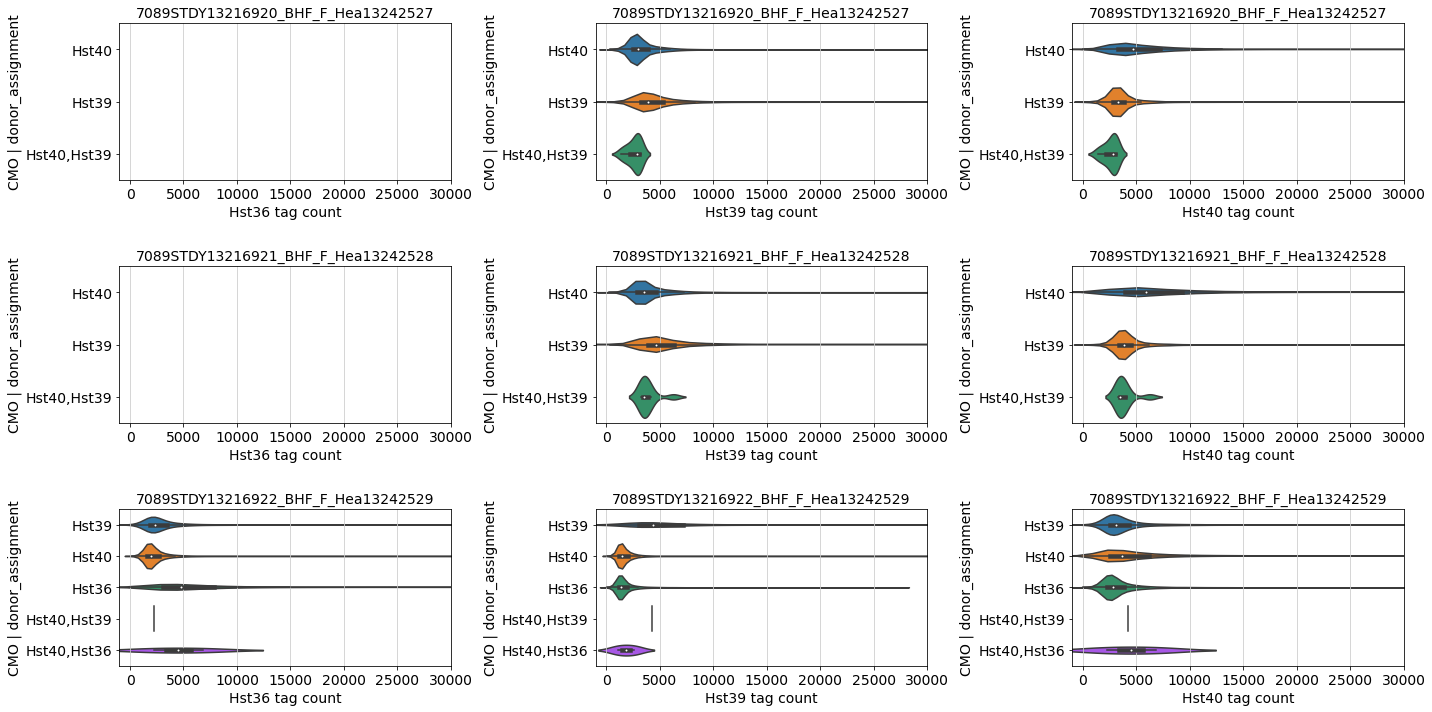

In [105]:
# multiplexed samples apart from '7089STDY13216923_BHF_F_Hea13242530'(no SOC assignment)
df = adata.obs[adata.obs['combinedID'].isin(['7089STDY13216920_BHF_F_Hea13242527',
                                             '7089STDY13216921_BHF_F_Hea13242528',
                                             '7089STDY13216922_BHF_F_Hea13242529',])]
print(df.shape)

donors = ['Hst36','Hst39','Hst40']
samples = ['7089STDY13216920_BHF_F_Hea13242527',
           '7089STDY13216921_BHF_F_Hea13242528',
           '7089STDY13216922_BHF_F_Hea13242529']

fig,axs = plt.subplots(nrows=3, ncols=3, figsize=(20,10)) 

for sam in samples:
    df_s = df[df['combinedID']==sam]
    
    for don in donors:
        row_no = samples.index(sam)
        col_no = donors.index(don)
        
        sns.violinplot(data=df_s, 
                       x=f'CMO | {don}',
                       y=f'CMO | donor_assignment',
                       ax=axs[row_no,col_no])
        axs[row_no,col_no].set_xlabel(f'{don} tag count')
        axs[row_no,col_no].set_title(sam)
        axs[row_no,col_no].set_xlim(-1000, 30000)

plt.tight_layout(h_pad=3.0)

(73111, 35)


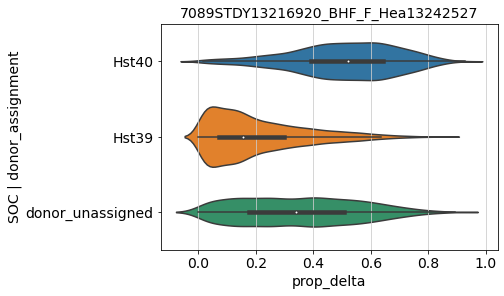

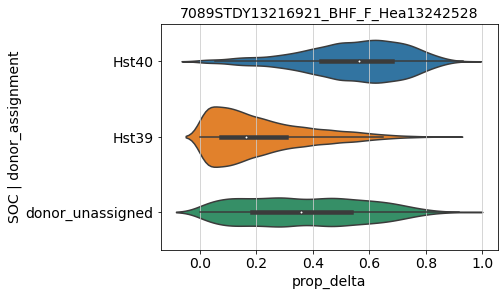

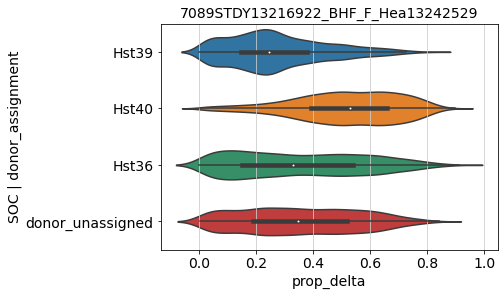

In [104]:
# multiplexed samples apart from '7089STDY13216923_BHF_F_Hea13242530'(no SOC assignment)
df = adata.obs[adata.obs['combinedID'].isin(['7089STDY13216920_BHF_F_Hea13242527',
                                             '7089STDY13216921_BHF_F_Hea13242528',
                                             '7089STDY13216922_BHF_F_Hea13242529',])]
print(df.shape)

donors = ['Hst36','Hst39','Hst40']
samples = ['7089STDY13216920_BHF_F_Hea13242527',
           '7089STDY13216921_BHF_F_Hea13242528',
           '7089STDY13216922_BHF_F_Hea13242529']

for sam in samples:
    df_s = df[df['combinedID']==sam]
        
    sns.violinplot(data=df_s, 
                   x=f'CMO | prop_delta',
                   y=f'SOC | donor_assignment')
    plt.xlabel('prop_delta')
    plt.title(sam)
    plt.show()

In [85]:
samples = ['7089STDY13216920_BHF_F_Hea13242527',
           '7089STDY13216921_BHF_F_Hea13242528',
           '7089STDY13216922_BHF_F_Hea13242529']
samples.index('7089STDY13216921_BHF_F_Hea13242528')

1

In [83]:
df[df['combinedID']=='7089STDY13216920_BHF_F_Hea13242527']

latent_RT_efficiency  \
barcode                                                                       
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1              7.888165   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1              7.925703   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1              6.652470   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1              6.054835   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1              5.798558   
...                                                                     ...   
7089STDY13216920_BHF_F_Hea13242527_GTCGAGGAGAGAGGAG-1              1.006664   
7089STDY13216920_BHF_F_Hea13242527_AGAGAGGAGGGTGGAT-1              0.525168   
7089STDY13216920_BHF_F_Hea13242527_CCAGACTCAAACTAAG-1              0.919330   
7089STDY13216920_BHF_F_Hea13242527_GATTGCGTCGACCTGA-1              0.640906   
7089STDY13216920_BHF_F_Hea13242527_TACTGGCCAGGATAAC-1              0.604866   

                                                       latent_cell_probability  \
barcode                                                                          
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1                 0.999996   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1                 0.999979   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1                 0.999995   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1                 0.999993   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1                 0.999992   
...                                                                        ...   
7089STDY13216920_BHF_F_Hea13242527_GTCGAGGAGAGAGGAG-1                 0.588466   
7089STDY13216920_BHF_F_Hea13242527_AGAGAGGAGGGTGGAT-1                 0.800743   
7089STDY13216920_BHF_F_Hea13242527_CCAGACTCAAACTAAG-1                 0.703016   
7089STDY13216920_BHF_F_Hea13242527_GATTGCGTCGACCTGA-1                 0.509635   
7089STDY13216920_BHF_F_Hea13242527_TACTGGCCAGGATAAC-1                 0.840650   

                                                       latent_scale  \
barcode                                                               
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  19645.132812   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  20618.298828   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  17098.843750   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  15610.971680   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  16973.482422   
...                                                             ...   
7089STDY13216920_BHF_F_Hea13242527_GTCGAGGAGAGAGGAG-1   8292.711914   
7089STDY13216920_BHF_F_Hea13242527_AGAGAGGAGGGTGGAT-1   4889.108398   
7089STDY13216920_BHF_F_Hea13242527_CCAGACTCAAACTAAG-1   6056.458008   
7089STDY13216920_BHF_F_Hea13242527_GATTGCGTCGACCTGA-1   6592.216797   
7089STDY13216920_BHF_F_Hea13242527_TACTGGCCAGGATAAC-1   6501.784180   

                                                               sangerID  \
barcode                                                                   
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  7089STDY13216920   
...                                                                 ...   
7089STDY13216920_BHF_F_Hea13242527_GTCGAGGAGAGAGGAG-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_AGAGAGGAGGGTGGAT-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_CCAGACTCAAACTAAG-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_GATTGCGTCGACCTGA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_TACTGGCCAGGATAAC-1  7089STDY13216920   

                                                            

In [80]:
adata.obs

latent_RT_efficiency  \
barcode                                                                       
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1              7.888165   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1              7.925703   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1              6.652470   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1              6.054835   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1              5.798558   
...                                                                     ...   
7089STDY13216927_BHF_F_Hea13242534_AGCACTTAGAGCCGGA-1              0.581353   
7089STDY13216927_BHF_F_Hea13242534_ACCTAAATCCAACTGG-1              0.624418   
7089STDY13216927_BHF_F_Hea13242534_ATAAGTCGTTTGGCGG-1              0.641219   
7089STDY13216927_BHF_F_Hea13242534_TATCGCGAGGCTACAT-1              0.768274   
7089STDY13216927_BHF_F_Hea13242534_AATTGCCAGCATGGTT-1              0.503387   

                                                       latent_cell_probability  \
barcode                                                                          
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1                 0.999996   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1                 0.999979   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1                 0.999995   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1                 0.999993   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1                 0.999992   
...                                                                        ...   
7089STDY13216927_BHF_F_Hea13242534_AGCACTTAGAGCCGGA-1                 0.992884   
7089STDY13216927_BHF_F_Hea13242534_ACCTAAATCCAACTGG-1                 0.988576   
7089STDY13216927_BHF_F_Hea13242534_ATAAGTCGTTTGGCGG-1                 0.987556   
7089STDY13216927_BHF_F_Hea13242534_TATCGCGAGGCTACAT-1                 0.686228   
7089STDY13216927_BHF_F_Hea13242534_AATTGCCAGCATGGTT-1                 0.640814   

                                                       latent_scale  \
barcode                                                               
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  19645.132812   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  20618.298828   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  17098.843750   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  15610.971680   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  16973.482422   
...                                                             ...   
7089STDY13216927_BHF_F_Hea13242534_AGCACTTAGAGCCGGA-1   4471.727051   
7089STDY13216927_BHF_F_Hea13242534_ACCTAAATCCAACTGG-1   3929.149658   
7089STDY13216927_BHF_F_Hea13242534_ATAAGTCGTTTGGCGG-1   4030.778809   
7089STDY13216927_BHF_F_Hea13242534_TATCGCGAGGCTACAT-1   4058.628662   
7089STDY13216927_BHF_F_Hea13242534_AATTGCCAGCATGGTT-1   3922.586670   

                                                               sangerID  \
barcode                                                                   
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  7089STDY13216920   
...                                                                 ...   
7089STDY13216927_BHF_F_Hea13242534_AGCACTTAGAGCCGGA-1  7089STDY13216927   
7089STDY13216927_BHF_F_Hea13242534_ACCTAAATCCAACTGG-1  7089STDY13216927   
7089STDY13216927_BHF_F_Hea13242534_ATAAGTCGTTTGGCGG-1  7089STDY13216927   
7089STDY13216927_BHF_F_Hea13242534_TATCGCGAGGCTACAT-1  7089STDY13216927   
7089STDY13216927_BHF_F_Hea13242534_AATTGCCAGCATGGTT-1  7089STDY13216927   

                                                            

In [40]:
df['combinedID']

{'7089STDY13216920_BHF_F_Hea13242527',
 '7089STDY13216921_BHF_F_Hea13242528',
 '7089STDY13216922_BHF_F_Hea13242529',
 '7089STDY13216923_BHF_F_Hea13242530'}

In [41]:
df = adata.obs[adata.obs['combinedID'].isin(multiplexed_samples)]
df['combinedID'] = df['combinedID'].astype('str')

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


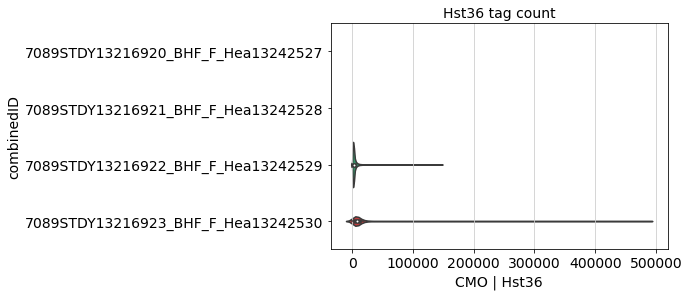

In [45]:
donor = 'Hst36'
sns.violinplot(data=df, x=f'CMO | {donor}', y="combinedID", vmax=5000)
plt.title(f'{donor} tag count')
plt.show()

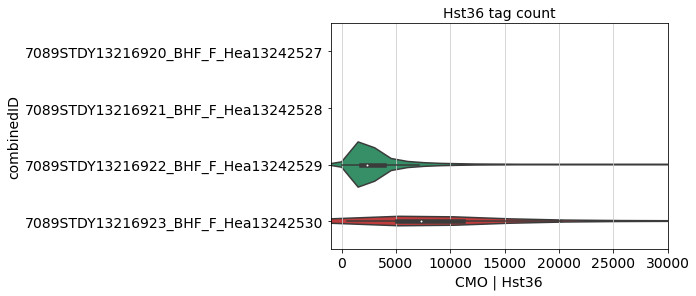

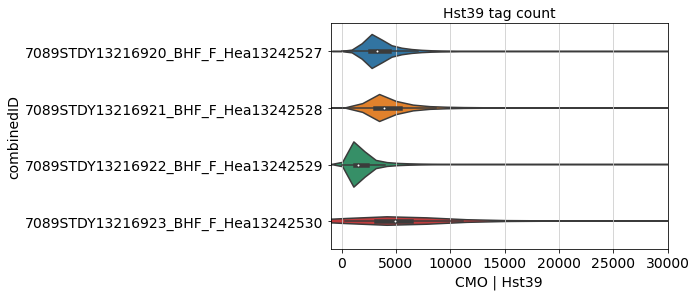

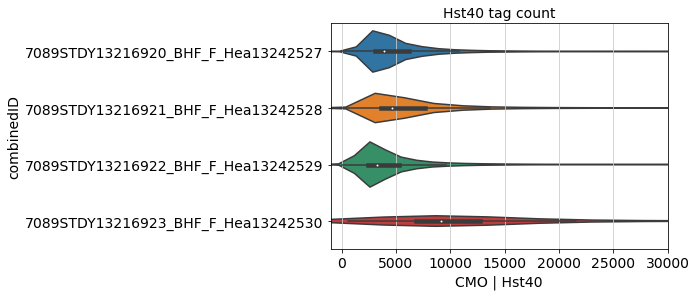

In [44]:
donor = 'Hst36'
sns.violinplot(data=df, x=f'CMO | {donor}', y="combinedID", vmax=5000)
plt.xlim(-1000, 30000)
plt.title(f'{donor} tag count')
plt.show()

donor = 'Hst39'
sns.violinplot(data=df, x=f'CMO | {donor}', y="combinedID", vmax=5000)
plt.xlim(-1000, 30000)
plt.title(f'{donor} tag count')
plt.show()

donor = 'Hst40'
sns.violinplot(data=df, x=f'CMO | {donor}', y="combinedID", vmax=5000)
plt.xlim(-1000, 30000)
plt.title(f'{donor} tag count')
plt.show()

In [52]:
multiplexed_samples

['7089STDY13216920_BHF_F_Hea13242527',
 '7089STDY13216921_BHF_F_Hea13242528',
 '7089STDY13216922_BHF_F_Hea13242529',
 '7089STDY13216923_BHF_F_Hea13242530']

In [54]:
pd.crosstab(df['SOC | donor_assignment'],df['CMO | donor_assignment'])

CMO | donor_assignment  Hst36  Hst39  Hst40  Hst40,Hst36  Hst40,Hst39
SOC | donor_assignment                                               
Hst36                    3559     73   1459            2            0
Hst39                     444  17144  18717            0           18
Hst40                     362    378  19505            0            1
donor_unassigned         1101   1475   8873            0            0

In [57]:
SOC_39_CMO_39 = df.index[(df['SOC | donor_assignment']=='Hst39')&(df['CMO | donor_assignment']=='Hst39')]
SOC_39_CMO_40 = df.index[(df['SOC | donor_assignment']=='Hst39')&(df['CMO | donor_assignment']=='Hst40')]
SOC_40_CMO_40 = df.index[(df['SOC | donor_assignment']=='Hst40')&(df['CMO | donor_assignment']=='Hst40')]
SOC_40_CMO_39 = df.index[(df['SOC | donor_assignment']=='Hst40')&(df['CMO | donor_assignment']=='Hst39')]

df['match_39-40'] = np.nan
df.loc[SOC_39_CMO_39,'match_39-40'] = 'SOC-39_CMO-39'
df.loc[SOC_39_CMO_40,'match_39-40'] = 'SOC-39_CMO-40'
df.loc[SOC_40_CMO_40,'match_39-40'] = 'SOC-40_CMO-40'
df.loc[SOC_40_CMO_39,'match_39-40'] = 'SOC-40_CMO-39'

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [62]:
df['match_39-40'] = df['match_39-40'].astype('category')
df['match_39-40'].cat.reorder_categories([
    'SOC-39_CMO-39',
    'SOC-39_CMO-40',
    'SOC-40_CMO-40',
    'SOC-40_CMO-39'
], inplace=True)

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


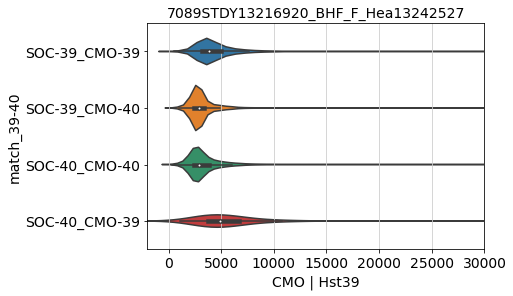

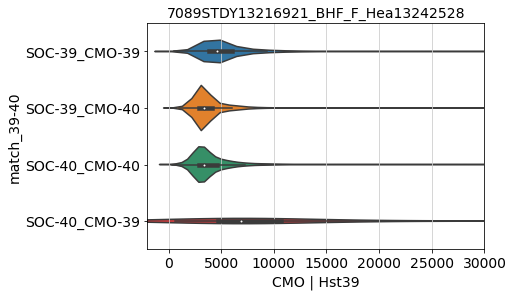

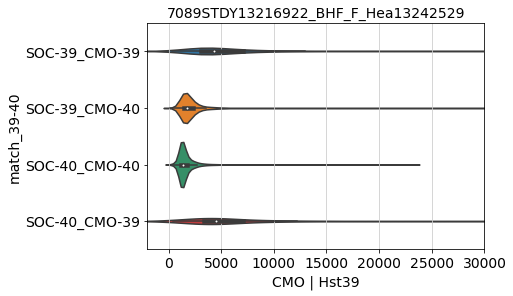

In [63]:
for sam in ['7089STDY13216920_BHF_F_Hea13242527',
 '7089STDY13216921_BHF_F_Hea13242528',
 '7089STDY13216922_BHF_F_Hea13242529']:
    df_s = df[df['combinedID']==sam]
    sns.violinplot(data=df_s, x='CMO | Hst39', y="match_39-40", vmax=5000)
    plt.xlim(-2000, 30000)
    plt.title(sam)
    plt.show()

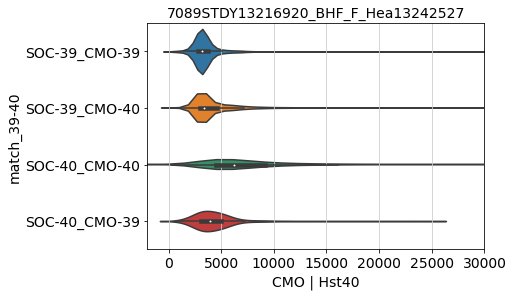

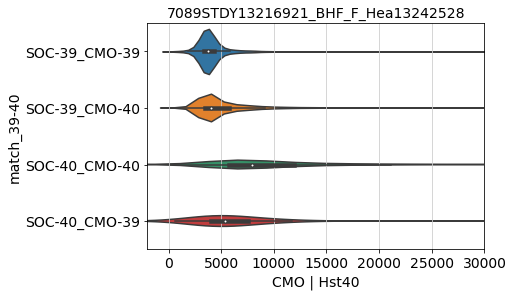

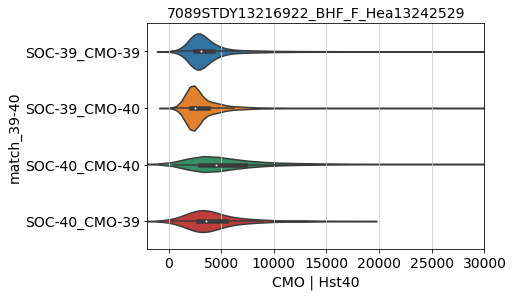

In [64]:
for sam in ['7089STDY13216920_BHF_F_Hea13242527',
 '7089STDY13216921_BHF_F_Hea13242528',
 '7089STDY13216922_BHF_F_Hea13242529']:
    df_s = df[df['combinedID']==sam]
    sns.violinplot(data=df_s, x='CMO | Hst40', y="match_39-40", vmax=5000)
    plt.xlim(-2000, 30000)
    plt.title(sam)
    plt.show()

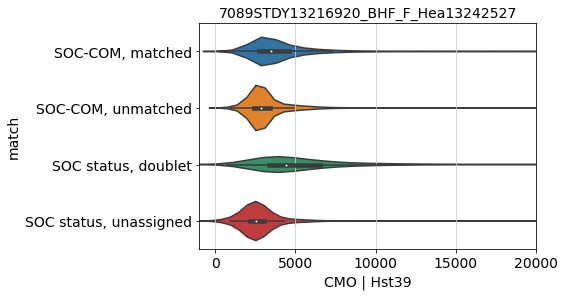

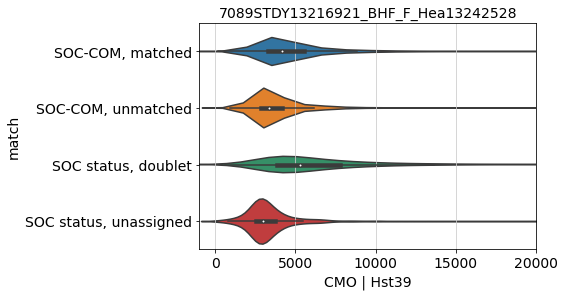

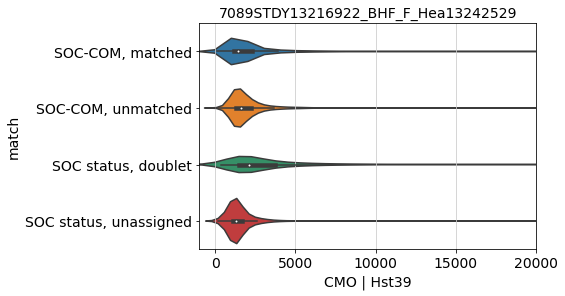

In [53]:
for sam in ['7089STDY13216920_BHF_F_Hea13242527',
 '7089STDY13216921_BHF_F_Hea13242528',
 '7089STDY13216922_BHF_F_Hea13242529']:
    df_s = df[df['combinedID']==sam]
    sns.violinplot(data=df_s, x='CMO | Hst39', y="match", vmax=5000)
    plt.xlim(-1000, 20000)
    plt.title(sam)
    plt.show()

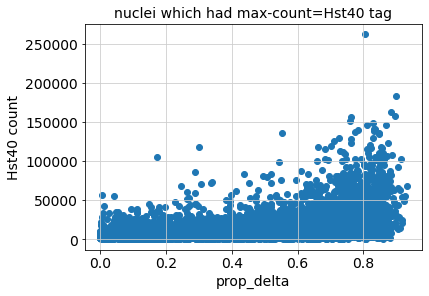

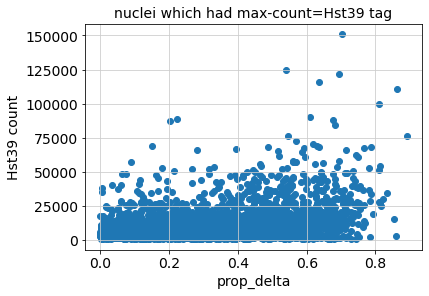

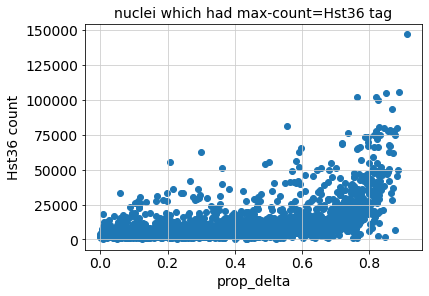

In [78]:
df - cmo

for don in set(df['CMO | donor_assignment']):
    
    if ',' not in don:
    
        df_s = df[df['CMO | donor_assignment']==don]
        plt.scatter(df_s['CMO | prop_delta'],df_s[f'CMO | {don}'])
        plt.title(f'nuclei which had max-count={don} tag')
        plt.xlabel('prop_delta')
        plt.ylabel(f'{don} count')
        plt.show()

In [79]:
df

latent_RT_efficiency  \
barcode                                                                       
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1              7.888165   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1              7.925703   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1              6.652470   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1              6.054835   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1              5.798558   
...                                                                     ...   
7089STDY13216922_BHF_F_Hea13242529_GGCTGAGAGGCAAGTA-1              0.577426   
7089STDY13216922_BHF_F_Hea13242529_GTAGCGCTCGTGCTTC-1              0.805462   
7089STDY13216922_BHF_F_Hea13242529_TCGGTTTGTCACACCC-1              0.446638   
7089STDY13216922_BHF_F_Hea13242529_TGCAATATCACAGACT-1              0.630163   
7089STDY13216922_BHF_F_Hea13242529_GCCACAATCCTAATAG-1              0.569418   

                                                       latent_cell_probability  \
barcode                                                                          
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1                 0.999996   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1                 0.999979   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1                 0.999995   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1                 0.999993   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1                 0.999992   
...                                                                        ...   
7089STDY13216922_BHF_F_Hea13242529_GGCTGAGAGGCAAGTA-1                 0.685279   
7089STDY13216922_BHF_F_Hea13242529_GTAGCGCTCGTGCTTC-1                 0.944718   
7089STDY13216922_BHF_F_Hea13242529_TCGGTTTGTCACACCC-1                 0.999644   
7089STDY13216922_BHF_F_Hea13242529_TGCAATATCACAGACT-1                 0.770298   
7089STDY13216922_BHF_F_Hea13242529_GCCACAATCCTAATAG-1                 0.999923   

                                                       latent_scale  \
barcode                                                               
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  19645.132812   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  20618.298828   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  17098.843750   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  15610.971680   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  16973.482422   
...                                                             ...   
7089STDY13216922_BHF_F_Hea13242529_GGCTGAGAGGCAAGTA-1   5878.484863   
7089STDY13216922_BHF_F_Hea13242529_GTAGCGCTCGTGCTTC-1   5715.777832   
7089STDY13216922_BHF_F_Hea13242529_TCGGTTTGTCACACCC-1   5305.336426   
7089STDY13216922_BHF_F_Hea13242529_TGCAATATCACAGACT-1   4536.293945   
7089STDY13216922_BHF_F_Hea13242529_GCCACAATCCTAATAG-1   5625.209961   

                                                               sangerID  \
barcode                                                                   
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1  7089STDY13216920   
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1  7089STDY13216920   
...                                                                 ...   
7089STDY13216922_BHF_F_Hea13242529_GGCTGAGAGGCAAGTA-1  7089STDY13216922   
7089STDY13216922_BHF_F_Hea13242529_GTAGCGCTCGTGCTTC-1  7089STDY13216922   
7089STDY13216922_BHF_F_Hea13242529_TCGGTTTGTCACACCC-1  7089STDY13216922   
7089STDY13216922_BHF_F_Hea13242529_TGCAATATCACAGACT-1  7089STDY13216922   
7089STDY13216922_BHF_F_Hea13242529_GCCACAATCCTAATAG-1  7089STDY13216922   

                                                            